# DSA4263 Modeling Steps: Weak Supervision for Insider Trading Detection

## 1. Data Description

- **SEC Form 4 Dataset:**  
  Contains transaction data including filing dates, transaction dates, amount transacted, number of shares traded, price per share, and remaining shares after transaction. These features are a mix of categorical, binary, and numerical data.
  
- **Network Data:**  
  A separate dataset from which we aim to derive features indicating political connections of insiders. (Note: "politically connected" is not yet fully defined.)

## 2. Labeling Challenge

- **Lack of Direct Labels:**  
  SEC Form 4 filings do not provide a clear indication of whether a transaction is unlawful.  
  - It is difficult to know if a suspicious transaction is due to a lack of evidence or other factors.
  - Training solely on SEC litigation press releases is problematic because of enforcement bias and the limited number of cases.

- **Our Goal:**  
  Instead of relying only on the few verified (ex‑post) SEC cases, we want to generate proxy labels that capture “suspiciousness” from multiple angles. This includes using metrics such as:
  - **Local Score (local_score_z):** Measures how much a transaction’s performance (e.g., its cumulative abnormal return or CAR) deviates from that of its local (peer) group.
  - **Isolation Score (isolation_z_score):** Reflects whether other similar transactions occur at the same time, with a high score suggesting the trade is isolated.
  - **CAR Metrics:** We compute CAR at different horizons (e.g., 30, 60, 120 days) and also adjust for sell transactions (effective_car).

  *Note:* Some of these metrics are transformed using a sigmoid function to map values into the [0,1] range.

## 3. Weak Supervision with Snorkel

Given the challenge of obtaining definitive labels for fraudulent insider trading, we use **weak supervision** via Snorkel. This approach involves:

1. **Defining Labeling Functions (LFs):**  
   - We write several domain-specific rules (or proxy metrics) that, when applied to a transaction, output a weak signal (or label).  
   - Examples include LFs that check whether the local score exceeds a threshold or whether the effective CAR is unusually high.
   - One can also include an LF that returns a positive label if a transaction is in a list of SEC-flagged cases.
   - <mark>***Since we do not have any acceptable number of labels which would provibe a non-noisy understanding of the data, we are forced to use it in snorkel to identify its overlap ??? with other metrics an investigator would be concerned about - car, z-score (abnormal returns at each time in a company), etc. the full list can be found below.***</mark>

2. **Generative (Label) Model:**  
   - Snorkel combines the outputs of all the LFs into an \(m \times n\) label matrix.
   - It then learns a generative model that estimates the accuracy and dependencies of each LF.
   - This model aggregates the LF votes into a single, probabilistic “silver label” for each transaction (a value in [0,1] representing the level of suspiciousness).

3. **Downstream (Discriminative) Model:**  
   - The silver labels produced by Snorkel are then used as the target variable to train a standard machine learning classifier (e.g., Random Forest, XGBoost, or neural networks).
   - Importantly, the features used to train this classifier are **ex-ante** (available at the time of the trade) and do not include any future (ex-post) information.

## 4. Key Definitions

- **Silver Label:**  
  The continuous probabilistic label ($y_i \in [0,1]$) produced by Snorkel’s generative model after aggregating the outputs of all labeling functions.

- **Generative (Label) Model:**  
  The model that estimates the accuracies and correlations of the labeling functions and combines their outputs into silver labels.

- **Discriminative Model:**  
  The downstream classifier that is trained on the ex-ante features using the silver labels as ground truth to predict suspicious transactions.

## 5. Summary of the Workflow

1. **Prepare the Data:**  
   Load the SEC Form 4 and network datasets; perform EDA and preprocessing.

2. **Define Labeling Functions:**  
   Create multiple LFs that output a weak label (1 for suspicious, or abstain) based on proxy metrics such as local scores, isolation scores, and CAR values.

3. **Apply Snorkel’s Pipeline:**  
   - Use the LFs to generate a label matrix.
   - Train Snorkel’s generative label model to obtain a silver label for each transaction.
   - (Optionally, if available, use a small validation set with known labels to evaluate LF performance.)

4. **Train a Downstream Classifier:**  
   Use ex-ante features (which do not include future data) and the silver labels as targets to train a final predictive model.

5. **Interpret and Validate:**  
   Analyze the model’s outputs (e.g., suspiciousness probabilities) for further investigation by domain experts.



In [56]:
# snorkel_pipeline_full.py

import pandas as pd
import numpy as np

# Corrected Snorkel imports
from snorkel.labeling import labeling_function, PandasLFApplier
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel

from snorkel.labeling.analysis import LFAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier


## Load DF

In [57]:

#############################################
# 2. Snorkel Pipeline with Validation Set Integration
#############################################

# Load your dataset (assumed to be in a CSV file)
df = pd.read_csv("all_transaction_final_final_with_anomaly_scores.csv", low_memory=False)
# Drop rows where "TRANS_CODE" equals "M"
df = df[df["TRANS_CODE"] != "M"]

# Optionally, reset the index
df = df.reset_index(drop=True)

# Check the first few rows
display(df.head())

print(df.columns)

df.columns = df.columns.str.replace("RPTOWNERCIK_;", "RPTOWNERCIK", regex=False)

df.columns



,TRANS_SK,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,DEEMED_EXECUTION_DATE,TRANS_CODE,EQUITY_SWAP_INVOLVED,TRANS_TIMELINESS,TRANS_SHARES,TRANS_PRICEPERSHARE,...,anomaly_score_120,local_score_30_sig,isolation_z_30_sig,anomaly_score_30_sig,local_score_60_sig,isolation_z_60_sig,anomaly_score_60_sig,local_score_120_sig,isolation_z_120_sig,anomaly_score_120_sig
0,4772101,0001090872-06-000001,Common Stock,2006-02-15,NaN,G,0,NaN,1103.0,0.00,...,-604.634303,0.500000,0.791331,-9.968990,1.000000,0.500000,-4.643766,1.000000,0.500000,-40.474635
1,4772102,0001090872-06-000001,Common Stock,2006-02-15,NaN,G,0,NaN,1103.0,0.00,...,1959.510046,0.500000,0.791331,9.968990,1.000000,0.500000,4.643766,1.000000,0.500000,40.474635
2,4859797,0001090872-06-000009,Common Stock,2006-03-17,NaN,S,0,NaN,40.0,38.06,...,-32.418558,0.960288,0.500000,6.758655,0.946749,0.500000,-13.658843,0.617166,0.500000,-53.223230
3,4859798,0001090872-06-000009,Common Stock,2006-03-17,NaN,S,0,NaN,46900.0,38.07,...,-32.418558,0.960288,0.500000,6.758655,0.946749,0.500000,-13.658843,0.617166,0.500000,-53.223230
4,5415355,0001090872-06-000010,Common Stock,2006-03-24,NaN,S,0,NaN,3600.0,37.32,...,-63.049192,0.500000,0.692380,3.778696,0.500000,0.748054,-18.016991,0.500000,0.811155,-69.699077


Index(['TRANS_SK', 'ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE',
       'DEEMED_EXECUTION_DATE', 'TRANS_CODE', 'EQUITY_SWAP_INVOLVED',
       'TRANS_TIMELINESS', 'TRANS_SHARES', 'TRANS_PRICEPERSHARE',
       'TRANS_ACQUIRED_DISP_CD', 'SHRS_OWND_FOLWNG_TRANS',
       'DIRECT_INDIRECT_OWNERSHIP', 'NATURE_OF_OWNERSHIP', 'trans_amt',
       'FILING_DATE', 'PERIOD_OF_REPORT', 'ISSUERCIK', 'ISSUERNAME',
       'ISSUERTRADINGSYMBOL', 'RPTOWNERCIK_;', 'NUM_RPTOWNERCIK',
       'RPTOWNERNAME_;', 'RPTOWNER_RELATIONSHIP_;', 'RPTOWNER_TITLE_#',
       'clean_ticker', 'is_weird_ticker', 'PERMNO', 'date_x', 'VOL', 'PRC',
       'RET', 'TICKER', 'date_y', 'actual_ret', 'b_mkt', 'risk_free_rate',
       'expected_ret', 'abnormal_ret', 'CAR_5_before', 'CAR_5_after',
       'CAR_30_before', 'CAR_30_after', 'CAR_60_before', 'CAR_60_after',
       'CAR_120_before', 'CAR_120_after', 'security_category',
       'effective_CAR_30_after', 'effective_CAR_60_after',
       'effective_CAR_120_after', 'loca

Index(['TRANS_SK', 'ACCESSION_NUMBER', 'SECURITY_TITLE', 'TRANS_DATE',
       'DEEMED_EXECUTION_DATE', 'TRANS_CODE', 'EQUITY_SWAP_INVOLVED',
       'TRANS_TIMELINESS', 'TRANS_SHARES', 'TRANS_PRICEPERSHARE',
       'TRANS_ACQUIRED_DISP_CD', 'SHRS_OWND_FOLWNG_TRANS',
       'DIRECT_INDIRECT_OWNERSHIP', 'NATURE_OF_OWNERSHIP', 'trans_amt',
       'FILING_DATE', 'PERIOD_OF_REPORT', 'ISSUERCIK', 'ISSUERNAME',
       'ISSUERTRADINGSYMBOL', 'RPTOWNERCIK', 'NUM_RPTOWNERCIK',
       'RPTOWNERNAME_;', 'RPTOWNER_RELATIONSHIP_;', 'RPTOWNER_TITLE_#',
       'clean_ticker', 'is_weird_ticker', 'PERMNO', 'date_x', 'VOL', 'PRC',
       'RET', 'TICKER', 'date_y', 'actual_ret', 'b_mkt', 'risk_free_rate',
       'expected_ret', 'abnormal_ret', 'CAR_5_before', 'CAR_5_after',
       'CAR_30_before', 'CAR_30_after', 'CAR_60_before', 'CAR_60_after',
       'CAR_120_before', 'CAR_120_after', 'security_category',
       'effective_CAR_30_after', 'effective_CAR_60_after',
       'effective_CAR_120_after', 'local_

In [58]:
#import pandas as pd

# Define the list of columns to extract
columns_to_extract = [
    "RPTOWNERCIK",
    "ACCESSION_NUMBER",
    "ISSUERCIK",
    "ISSUERNAME",
    "RPTOWNERNAME_;",
    "RPTOWNER_RELATIONSHIP_;"
]

# Extract the desired columns from df
df_subset = df[columns_to_extract]

# Create a DataFrame with just the owner names and their CIK, dropping duplicates
unique_owners = df_subset[['RPTOWNERNAME_;', 'RPTOWNERCIK']].drop_duplicates()

# Rename the columns:
# 1. Remove the weird '_;' from the owner name column
# 2. Prefix both columns with 'SEC_'
unique_owners = unique_owners.rename(columns={
    'RPTOWNERNAME_;': 'SEC_RPTOWNERNAME',
    'RPTOWNERCIK': 'SEC_RPTOWNERCIK'
})

# Now unique_owners contains two columns: 'SEC_RPTOWNERNAME' and 'SEC_RPTOWNERCIK'
print(unique_owners.shape)


(136224, 2)


In [59]:
unique_owners.to_csv("namelist.csv")

In [60]:
df.to_csv("name_list_9mil.csv")

In [61]:
# Compute trader-level means for effective CAR metrics
trader_mean_car_30 = df.groupby("RPTOWNERCIK")["effective_CAR_30_after"].mean().rename("trader_mean_car_30")
trader_mean_car_60 = df.groupby("RPTOWNERCIK")["effective_CAR_60_after"].mean().rename("trader_mean_car_60")
trader_mean_car_120 = df.groupby("RPTOWNERCIK")["effective_CAR_120_after"].mean().rename("trader_mean_car_120")

# Merge these averages back into the main DataFrame (df)
df = df.merge(trader_mean_car_30, on="RPTOWNERCIK", how="left")
df = df.merge(trader_mean_car_60, on="RPTOWNERCIK", how="left")
df = df.merge(trader_mean_car_120, on="RPTOWNERCIK", how="left")

# Now df contains the new columns: trader_mean_car_30, trader_mean_car_60, trader_mean_car_120
display(df.head())
import pandas as pd

# Suppose df is your entire dataset, after removing "M" codes, etc.

# 1) Compute trader-level average effective CAR
df["TRANS_DATE"] = pd.to_datetime(df["TRANS_DATE"])  # ensure date

# Sort so groupby shift will work consistently for last trade date logic
df = df.sort_values(["RPTOWNERCIK", "TRANS_DATE"]).reset_index(drop=True)


# 2) Compute global means if you want them
global_mean_car_30 = df["effective_CAR_30_after"].mean()
global_mean_car_60 = df["effective_CAR_60_after"].mean()
global_mean_car_120 = df["effective_CAR_120_after"].mean()

# 3) Compute trader-level average volume
trader_mean_volume = df.groupby("RPTOWNERCIK")["TRANS_SHARES"].mean().rename("trader_mean_volume")

# 4) (Optional) Compute the last trade date per trader
last_trade_series = df.groupby("RPTOWNERCIK")["TRANS_DATE"].shift(1)
last_trade = df.groupby("RPTOWNERCIK")["TRANS_DATE"].last().to_dict()

# 5) Merge the computed averages back into df
df = df.merge(trader_mean_car_30, on="RPTOWNERCIK", how="left")
df = df.merge(trader_mean_car_60, on="RPTOWNERCIK", how="left")
df = df.merge(trader_mean_car_120, on="RPTOWNERCIK", how="left")
df = df.merge(trader_mean_volume, on="RPTOWNERCIK", how="left")

# Optionally store global means somewhere
# e.g. a dictionary:
global_means = {
    "car_30": global_mean_car_30,
    "car_60": global_mean_car_60,
    "car_120": global_mean_car_120
}

# Now df has columns:
#  trader_mean_car_30, trader_mean_car_60, trader_mean_car_120, trader_mean_volume
# plus the original ones
print(df.head())


,TRANS_SK,ACCESSION_NUMBER,SECURITY_TITLE,TRANS_DATE,DEEMED_EXECUTION_DATE,TRANS_CODE,EQUITY_SWAP_INVOLVED,TRANS_TIMELINESS,TRANS_SHARES,TRANS_PRICEPERSHARE,...,anomaly_score_30_sig,local_score_60_sig,isolation_z_60_sig,anomaly_score_60_sig,local_score_120_sig,isolation_z_120_sig,anomaly_score_120_sig,trader_mean_car_30,trader_mean_car_60,trader_mean_car_120
0,4772101,0001090872-06-000001,Common Stock,2006-02-15,NaN,G,0,NaN,1103.0,0.00,...,-9.968990,1.000000,0.500000,-4.643766,1.000000,0.500000,-40.474635,-0.890347,-0.323787,-1.742335
1,4772102,0001090872-06-000001,Common Stock,2006-02-15,NaN,G,0,NaN,1103.0,0.00,...,9.968990,1.000000,0.500000,4.643766,1.000000,0.500000,40.474635,-0.890347,-0.323787,-1.742335
2,4859797,0001090872-06-000009,Common Stock,2006-03-17,NaN,S,0,NaN,40.0,38.06,...,6.758655,0.946749,0.500000,-13.658843,0.617166,0.500000,-53.223230,-6.378030,-13.562040,-23.780903
3,4859798,0001090872-06-000009,Common Stock,2006-03-17,NaN,S,0,NaN,46900.0,38.07,...,6.758655,0.946749,0.500000,-13.658843,0.617166,0.500000,-53.223230,-6.378030,-13.562040,-23.780903
4,5415355,0001090872-06-000010,Common Stock,2006-03-24,NaN,S,0,NaN,3600.0,37.32,...,3.778696,0.500000,0.748054,-18.016991,0.500000,0.811155,-69.699077,1.488513,-6.871257,-25.655479


   TRANS_SK      ACCESSION_NUMBER SECURITY_TITLE TRANS_DATE  \
0   3794004  0001181431-09-023155   Common Stock 2009-05-04   
1   2834113  0001181431-12-005367   Common Stock 2012-01-31   
2   3043733  0001181431-12-047732   Common Stock 2012-08-03   
3   3043734  0001181431-12-047732   Common Stock 2012-08-07   
4   3043284  0001181431-12-049839   Common Stock 2012-09-07   

  DEEMED_EXECUTION_DATE TRANS_CODE EQUITY_SWAP_INVOLVED TRANS_TIMELINESS  \
0                   NaN          S                    0              NaN   
1                   NaN          S                    0              NaN   
2                   NaN          S                    0              NaN   
3                   NaN          S                    0              NaN   
4                   NaN          S                    0              NaN   

   TRANS_SHARES  TRANS_PRICEPERSHARE  ... local_score_120_sig  \
0        1940.0                13.00  ...            0.997148   
1        4000.0                16.

In [62]:


# 2) Read your 50 known positives
df_gt = pd.read_csv("ground_truth_matching_keys.csv")
# This file presumably has columns ["ACCESSION_NUMBER", "TRANS_SK"] for the known positives
print(df_gt.shape)
# 3) Merge on those columns
df_merged = df.merge(df_gt, on=["ACCESSION_NUMBER", "TRANS_SK"], how="left", indicator=True)

# 4) Create an 'external_validation' column with 1 if it’s in the known positives, else 0
df_merged["external_validation"] = (df_merged["_merge"] == "both").astype(int)
df_merged.drop(columns=["_merge"], inplace=True)

# Now df_merged is your single dataset with a column external_validation = 1 for known positives, 0 for others
print("Total known positives:", df_merged["external_validation"].sum())

# If you do NOT want to split further, just rename df_merged back to df
df = df_merged


df_D = df[df["TRANS_ACQUIRED_DISP_CD"] == "D"].copy()
df_A = df[df["TRANS_ACQUIRED_DISP_CD"] == "A"].copy()

(256, 2)
Total known positives: 223


## some buy txs are a bit wonky.

In [63]:
# Create a mask for rows where TRANS_SHARES > SHRS_OWND_FOLWNG_TRANS
mask_before = df_A["TRANS_SHARES"] > df_A["SHRS_OWND_FOLWNG_TRANS"]

# Update only those rows: set SHRS_OWND_FOLWNG_TRANS equal to TRANS_SHARES
df_A.loc[mask_before, "SHRS_OWND_FOLWNG_TRANS"] = df_A.loc[mask_before, "TRANS_SHARES"]

# Now, check that these rows have been updated.
# We re-compute a mask to see if any row still has TRANS_SHARES > SHRS_OWND_FOLWNG_TRANS.
mask_after = df_A["TRANS_SHARES"] > df_A["SHRS_OWND_FOLWNG_TRANS"]

print("Number of rows updated (before):", mask_before.sum())
print("Number of rows still where TRANS_SHARES > SHRS_OWND_FOLWNG_TRANS (after):", mask_after.sum())

# Optionally, print a few rows from those that were updated:
print("Sample updated rows:")
print(df_A.loc[mask_before, ["TRANS_SHARES", "SHRS_OWND_FOLWNG_TRANS"]].head())


Number of rows updated (before): 3464
Number of rows still where TRANS_SHARES > SHRS_OWND_FOLWNG_TRANS (after): 0
Sample updated rows:
     TRANS_SHARES  SHRS_OWND_FOLWNG_TRANS
26      7047261.0               7047261.0
710         100.0                   100.0
711         100.0                   100.0
712        1000.0                  1000.0
713         100.0                   100.0


## Sell txns: Computing new metrics

In [35]:
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm

# Enable tqdm progress_apply for DataFrame if needed.
tqdm.pandas()

# Load your data using pandas (adjust file path as needed)
#df_D = pd.read_csv("path/to/df_D.csv", low_memory=False)

def compute_zscore(x):
    std_val = x.std(ddof=1)
    if std_val == 0 or np.isnan(std_val):
        return x - x.mean()
    else:
        return (x - x.mean()) / std_val

def compute_zscore_peer(x):
    std_val = x.std(ddof=1)
    if std_val == 0 or np.isnan(std_val):
        return x - x.mean()
    else:
        return (x - x.mean()) / std_val

def compute_zscore_turnover(x):
    std_val = x.std(ddof=1)
    if std_val == 0 or np.isnan(std_val):
        return x - x.mean()
    else:
        return (x - x.mean()) / std_val

def compute_abnormal_volume_and_turnover(df):
    """
    Computes metrics for each row in a pandas DataFrame df (all sell transactions):
    
    1. Accession Insider Volume:
       Group by (ISSUERTRADINGSYMBOL, ACCESSION_NUMBER) and sum TRANS_SHARES.
       Merge back as 'accession_insider_volume'.
    
    2. Volume vs. Market (volume_mkt_sig):
       volume_mkt_ratio = accession_insider_volume / VOL.
       Group by ISSUERTRADINGSYMBOL, compute z-score and apply sigmoid.
    
    3. Volume vs. Peer Insiders (volume_peer_sig):
       For each ISSUERTRADINGSYMBOL, sum TRANS_SHARES to get ticker_total_insider_shares.
       volume_peer_ratio = accession_insider_volume / ticker_total_insider_shares.
       Group by ISSUERTRADINGSYMBOL, compute z-score and apply sigmoid.
    
    4. Turnover Ratio & Sigmoid:
       turnover_ratio = TRANS_SHARES / (TRANS_SHARES + SHRS_OWND_FOLWNG_TRANS) (clipped at 0).
       Group by ISSUERTRADINGSYMBOL, compute z-score and apply sigmoid.
    
    5. Cumulative Turnover:
       Group by ACCESSION_NUMBER, sum TRANS_SHARES and SHRS_OWND_FOLWNG_TRANS, then compute
       cumulative_turnover = total_TRANS_SHARES / (total_TRANS_SHARES + total_SHRS_OWND_FOLWNG_TRANS).
       Merge back on ACCESSION_NUMBER.
    
    Returns the DataFrame with these new columns.
    """
    df = df.copy()
    
    print("Step 1: Computing Accession Insider Volume...")
    agg_acc_vol = df.groupby(["ISSUERTRADINGSYMBOL", "ACCESSION_NUMBER"])["TRANS_SHARES"].sum().reset_index()
    agg_acc_vol = agg_acc_vol.rename(columns={"TRANS_SHARES": "accession_insider_volume"})
    df = df.merge(agg_acc_vol, on=["ISSUERTRADINGSYMBOL", "ACCESSION_NUMBER"], how="left")
    print("Accession Insider Volume computed.")
    
    print("Step 2: Computing Volume vs. Market...")
    df["volume_mkt_ratio"] = df["accession_insider_volume"] / df["VOL"]
    # Compute z-score by group (vectorized)
    df["volume_mkt_z"] = df.groupby("ISSUERTRADINGSYMBOL")["volume_mkt_ratio"].transform(compute_zscore)
    df["volume_mkt_sig"] = 1 / (1 + np.exp(-df["volume_mkt_z"].fillna(0)))
    print("Volume vs. Market computed.")
    
    print("Step 3: Computing Volume vs. Peer Insiders...")
    ticker_totals = df.groupby("ISSUERTRADINGSYMBOL")["TRANS_SHARES"].sum().reset_index()
    ticker_totals = ticker_totals.rename(columns={"TRANS_SHARES": "ticker_total_insider_shares"})
    df = df.merge(ticker_totals, on="ISSUERTRADINGSYMBOL", how="left")
    df["volume_peer_ratio"] = df["accession_insider_volume"] / df["ticker_total_insider_shares"]
    df["volume_peer_z"] = df.groupby("ISSUERTRADINGSYMBOL")["volume_peer_ratio"].transform(compute_zscore_peer)
    df["volume_peer_sig"] = 1 / (1 + np.exp(-df["volume_peer_z"].fillna(0)))
    print("Volume vs. Peer Insiders computed.")
    
    print("Step 4: Computing Turnover metrics...")
    df["turnover_ratio"] = df["TRANS_SHARES"] / (df["TRANS_SHARES"] + df["SHRS_OWND_FOLWNG_TRANS"])
    df["turnover_ratio"] = df["turnover_ratio"].clip(lower=0)
    df["turnover_z"] = df.groupby("ISSUERTRADINGSYMBOL")["turnover_ratio"].transform(compute_zscore_turnover)
    df["turnover_sig"] = 1 / (1 + np.exp(-df["turnover_z"].fillna(0)))
    print("Turnover metrics computed.")
    
    print("Step 5: Computing Cumulative Turnover...")
    agg = df.groupby("ACCESSION_NUMBER")[["TRANS_SHARES", "SHRS_OWND_FOLWNG_TRANS"]].sum().reset_index()
    agg["cumulative_turnover"] = agg["TRANS_SHARES"] / (agg["TRANS_SHARES"] + agg["SHRS_OWND_FOLWNG_TRANS"])
    df = df.merge(agg[["ACCESSION_NUMBER", "cumulative_turnover"]], on="ACCESSION_NUMBER", how="left")
    print("Cumulative Turnover computed.")
    
    return df


In [6]:



# ================= Example Usage =================
print("Starting overall computation with tqdm progress...")
# Read the CSV directly using pandas (you can save and re-read to avoid recomputation)

# Use tqdm to wrap the overall computation (if desired, here we simply print progress messages)
df_D_new = compute_abnormal_volume_and_turnover(df_D)

# Optionally, save the computed DataFrame to CSV for future use.
df_D_new.to_csv("df_D_new_metrics.csv", index=False)
print("Computed DataFrame saved to CSV.")

# Then print summary statistics.
print("=== Summaries of New Metrics ===")
print("\nTurnover Ratio Summary:")
print(df_D_new["turnover_ratio"].describe())

if "volume_mkt_sig" in df_D_new.columns:
    print("\nVolume Market Signal (volume_mkt_sig) Summary:")
    print(df_D_new["volume_mkt_sig"].describe())
else:
    print("\nVolume Insider Signal (volume_insider_sig) Summary:")
    print(df_D_new["volume_insider_sig"].describe())

print("\nTurnover Z and Sigmoid Summaries:")
print(df_D_new["turnover_z"].describe())
print(df_D_new["turnover_sig"].describe())

print("\nCumulative Turnover Summary (by ACCESSION_NUMBER):")
cumulative_summary = df_D_new.groupby("ACCESSION_NUMBER")["cumulative_turnover"].first().describe()
print(cumulative_summary)



Starting overall computation with tqdm progress...
Step 1: Computing Accession Insider Volume...
Accession Insider Volume computed.
Step 2: Computing Volume vs. Market...


C:\Users\65882\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Volume vs. Market computed.
Step 3: Computing Volume vs. Peer Insiders...
Volume vs. Peer Insiders computed.
Step 4: Computing Turnover metrics...
Turnover metrics computed.
Step 5: Computing Cumulative Turnover...
Cumulative Turnover computed.
Computed DataFrame saved to CSV.
=== Summaries of New Metrics ===

Turnover Ratio Summary:
count    2.340807e+06
mean     1.272626e-01
std      2.576083e-01
min      0.000000e+00
25%      1.381446e-03
50%      1.234365e-02
75%      9.706245e-02
max      1.000000e+00
Name: turnover_ratio, dtype: float64

Volume Market Signal (volume_mkt_sig) Summary:
count    2.341978e+06
mean     4.782616e-01
std      1.372010e-01
min      0.000000e+00
25%      4.147525e-01
50%      4.567198e-01
75%      4.954769e-01
max      1.000000e+00
Name: volume_mkt_sig, dtype: float64

Turnover Z and Sigmoid Summaries:
count    2.340807e+06
mean    -1.046430e-06
std      9.976842e-01
min     -8.478834e+00
25%     -4.350872e-01
50%     -2.653239e-01
75%     -6.455845e-02
m

## Buy txns: same thing

In [67]:

def compute_abnormal_volume_and_turnover_buys(df):
    """
    Computes various metrics for buy transactions.
    
    This version is adapted for buys because the turnover metrics differ for buys.
    
    1. Accession Insider Volume:
       Group by (ISSUERTRADINGSYMBOL, ACCESSION_NUMBER) and sum TRANS_SHARES.
       Merge back as 'accession_insider_volume'.
    
    2. Volume vs. Market (volume_mkt_sig):
       volume_mkt_ratio = accession_insider_volume / VOL.
       Group by ISSUERTRADINGSYMBOL, compute z-score and apply sigmoid.
    
    3. Volume vs. Peer Insiders (volume_peer_sig):
       Compute ticker_total_insider_shares as the sum of TRANS_SHARES per ISSUERTRADINGSYMBOL.
       volume_peer_ratio = accession_insider_volume / ticker_total_insider_shares.
       Group by ISSUERTRADINGSYMBOL, compute z-score and apply sigmoid.
    
    4. Turnover Ratio for Buys:
       For buys, compute turnover_ratio_buy = TRANS_SHARES / SHRS_OWND_FOLWNG_TRANS,
       taking care to avoid division by zero.
       Then compute a z-score and apply sigmoid.
    
    5. Cumulative Turnover for Buys:
       Group by ACCESSION_NUMBER and sum TRANS_SHARES and SHRS_OWND_FOLWNG_TRANS.
       Compute cumulative_turnover_buy = total_TRANS_SHARES / total_SHRS_OWND_FOLWNG_TRANS
       (again, handle division by zero).
    
    Returns the DataFrame with new columns.
    """
    df = df.copy()
    
    # Step 1: Compute Accession Insider Volume (same for buys and sells)
    agg_acc_vol = df.groupby(["ISSUERTRADINGSYMBOL", "ACCESSION_NUMBER"])["TRANS_SHARES"].sum().reset_index()
    agg_acc_vol = agg_acc_vol.rename(columns={"TRANS_SHARES": "accession_insider_volume"})
    df = df.merge(agg_acc_vol, on=["ISSUERTRADINGSYMBOL", "ACCESSION_NUMBER"], how="left")
    
    # Step 2: Volume vs. Market
    df["volume_mkt_ratio"] = df["accession_insider_volume"] / df["VOL"]
    df["volume_mkt_z"] = df.groupby("ISSUERTRADINGSYMBOL")["volume_mkt_ratio"].transform(compute_zscore)
    df["volume_mkt_sig"] = 1 / (1 + np.exp(-df["volume_mkt_z"].fillna(0)))
    
    # Step 3: Volume vs. Peer Insiders
    ticker_totals = df.groupby("ISSUERTRADINGSYMBOL")["TRANS_SHARES"].sum().reset_index()
    ticker_totals = ticker_totals.rename(columns={"TRANS_SHARES": "ticker_total_insider_shares"})
    df = df.merge(ticker_totals, on="ISSUERTRADINGSYMBOL", how="left")
    df["volume_peer_ratio"] = df["accession_insider_volume"] / df["ticker_total_insider_shares"]
    df["volume_peer_z"] = df.groupby("ISSUERTRADINGSYMBOL")["volume_peer_ratio"].transform(compute_zscore_peer)
    df["volume_peer_sig"] = 1 / (1 + np.exp(-df["volume_peer_z"].fillna(0)))
    
    # Step 4: Turnover Ratio for Buys
    # For buys, the new holdings (SHRS_OWND_FOLWNG_TRANS) represent the updated share count after the purchase.
    # We define turnover_ratio_buy = TRANS_SHARES / SHRS_OWND_FOLWNG_TRANS.
    # Use a lambda that avoids division by zero.
    df["turnover_ratio"] = df.apply(
        lambda row: row["TRANS_SHARES"] / row["SHRS_OWND_FOLWNG_TRANS"] if row["SHRS_OWND_FOLWNG_TRANS"] > 0 else np.nan,
        axis=1
    )
    df["turnover_z"] = df.groupby("ISSUERTRADINGSYMBOL")["turnover_ratio"].transform(compute_zscore_turnover)
    df["turnover_sig"] = 1 / (1 + np.exp(-df["turnover_z"].fillna(0)))
    
    # Step 5: Cumulative Turnover for Buys
    # For each ACCESSION_NUMBER, compute the total TRANS_SHARES and total SHRS_OWND_FOLWNG_TRANS.
    agg = df.groupby("ACCESSION_NUMBER")[["TRANS_SHARES", "SHRS_OWND_FOLWNG_TRANS"]].sum().reset_index()
    agg["cumulative_turnover"] = agg.apply(
        lambda row: row["TRANS_SHARES"] / row["SHRS_OWND_FOLWNG_TRANS"] if row["SHRS_OWND_FOLWNG_TRANS"] > 0 else np.nan,
        axis=1
    )
    df = df.merge(agg[["ACCESSION_NUMBER", "cumulative_turnover"]], on="ACCESSION_NUMBER", how="left")
    
    return df

In [68]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Enable tqdm progress_apply for DataFrames
tqdm.pandas()

#df_A_new = df_A_new[df_A_new["TRANS_CODE"] != "S"]

# Force SHRS_OWND_FOLWNG_TRANS to equal TRANS_SHARES for any row where they differ

print("Starting overall computation for buys with tqdm progress...")
# Compute metrics for buy transactions
df_A_new = compute_abnormal_volume_and_turnover_buys(df_A)

# Rename buy-specific columns to match sell columns (for later concatenation)


# Optionally, save the computed DataFrame to CSV for future use.
df_A_new.to_csv("df_A_new_metrics.csv", index=False)
print("Computed DataFrame saved to CSV.")

# Then print summary statistics.
print("=== Summaries of New Metrics ===")

print("\nTurnover Ratio Summary:")
print(df_A_new["turnover_ratio"].describe())

if "volume_mkt_sig" in df_A_new.columns:
    print("\nVolume Market Signal (volume_mkt_sig) Summary:")
    print(df_A_new["volume_mkt_sig"].describe())
else:
    print("\nVolume Insider Signal (volume_insider_sig) Summary:")
    print(df_A_new["volume_insider_sig"].describe())

print("\nTurnover Z and Sigmoid Summaries:")
print(df_A_new["turnover_z"].describe())
print(df_A_new["turnover_sig"].describe())

print("\nCumulative Turnover Summary (by ACCESSION_NUMBER):")
cumulative_summary = df_A_new.groupby("ACCESSION_NUMBER")["cumulative_turnover"].first().describe()
print(cumulative_summary)


Starting overall computation for buys with tqdm progress...


C:\Users\65882\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Computed DataFrame saved to CSV.
=== Summaries of New Metrics ===

Turnover Ratio Summary:
count    827440.000000
mean          0.157797
std           0.302407
min           0.000000
25%           0.001709
50%           0.012485
75%           0.116732
max           1.000000
Name: turnover_ratio, dtype: float64

Volume Market Signal (volume_mkt_sig) Summary:
count    829023.000000
mean          0.447526
std           0.180592
min           0.000000
25%           0.397378
50%           0.454711
75%           0.494322
max           1.000000
Name: volume_mkt_sig, dtype: float64

Turnover Z and Sigmoid Summaries:
count    827440.000000
mean          0.000010
std           0.993230
min          -7.857803
25%          -0.433323
50%          -0.252728
75%          -0.062688
max          42.296545
Name: turnover_z, dtype: float64
count    829023.000000
mean          0.480314
std           0.157652
min           0.000387
25%           0.393454
50%           0.437326
75%           0.484772
max   

### Computing more metrics!

### This is our gold label LF. Despite the generally small size, we are hoping that it'll add a good discriminating dimension to our 20 other LFs.


In [69]:
# snorkel_pipeline_full.py

import pandas as pd
import numpy as np

# Corrected Snorkel imports
from snorkel.labeling import labeling_function, PandasLFApplier
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel

from snorkel.labeling.analysis import LFAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier


df_D = pd.read_csv("df_D_new_metrics.csv")
df_A = pd.read_csv("df_A_new_metrics.csv")


C:\Users\65882\AppData\Local\Temp\ipykernel_26152\723536418.py:17: DtypeWarning: Columns (4,6,7,13,20,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_D = pd.read_csv("df_D_new_metrics.csv")
C:\Users\65882\AppData\Local\Temp\ipykernel_26152\723536418.py:18: DtypeWarning: Columns (6,20,24,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_A = pd.read_csv("df_A_new_metrics.csv")


In [70]:
from snorkel.labeling import labeling_function

ABSTAIN = -1
SUSPICIOUS = 1
SAFE = 0  # We'll explicitly return 0 for non-suspicious



@labeling_function()
def lf_known_fraud(txn):
    """
    For gold-labeled transactions (external_validation == 1):
      - If any of effective_CAR_30_after, effective_CAR_60_after, or effective_CAR_120_after is positive, 
        label as SUSPICIOUS.
      - Else if all three effective CAR values are below -10, label as SAFE.
      - Otherwise, label as SUSPICIOUS.
    For transactions not in the gold set, abstain.
    """
    if txn.get("external_validation") == 1:
        # Get the effective CAR values (if missing, they may be None)
        car30 = txn.get("effective_CAR_30_after")
        car60 = txn.get("effective_CAR_60_after")
        car120 = txn.get("effective_CAR_120_after")
        
        # Check if any of them is positive.
        if ((car30 is not None and car30 > 0) or 
            (car60 is not None and car60 > 0) or 
            (car120 is not None and car120 > 0)):
            return SUSPICIOUS
        
        # If all three values are present and below -10, mark as SAFE.
        if (car30 is not None and car60 is not None and car120 is not None and 
            car30 <= 0 and car60 <= 0 and car120 <= 0):
            return SAFE
        
        # Otherwise, default to suspicious.
        return ABSTAIN
    # For non-gold transactions, abstain.
    return ABSTAIN


## Other labelling functions, derived from general domain knowledge and known indicators of suspicion.

We justify each metric's threshold in the appendix.

In [71]:

##########################
# Basic Numeric LFs
##########################

@labeling_function()
def lf_local_30_sig(txn, threshold=0.45):
    """Sigmoided Local Score at 30 Days: flag if > 0.45."""
    val = txn.get("local_score_30_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN
@labeling_function()
def lf_local_30_sig_6(txn, threshold=0.84):
    """Sigmoided Local Score at 30 Days: flag if > 0.45."""
    val = txn.get("local_score_30_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN


@labeling_function()
def lf_local_60_sig(txn, threshold=0.45):
    """Sigmoided Local Score at 60 Days: flag if > 0.45."""
    val = txn.get("local_score_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_60_sig_3(txn, threshold=0.5):
    """Sigmoided Local Score at 60 Days: flag if > 0.45."""
    val = txn.get("local_score_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_60_sig_6(txn, threshold=0.6):
    """Sigmoided Local Score at 60 Days: flag if > 0.45."""
    val = txn.get("local_score_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN


@labeling_function()
def lf_local_120_sig(txn, threshold=0.45):
    """Sigmoided Local Score at 120 Days: flag if > 0.45."""
    val = txn.get("local_score_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_120_sig_48(txn, threshold=0.48): # changed from 4.5
    """Sigmoided Local Score at 120 Days: flag if > 0.45."""
    val = txn.get("local_score_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_120_sig_55(txn, threshold=0.5): # changed from 4.5
    """Sigmoided Local Score at 120 Days: flag if > 0.45."""
    val = txn.get("local_score_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_120_sig_75(txn, threshold=0.75):
    """Sigmoided Local Score at 120 Days: flag if > 0.45."""
    val = txn.get("local_score_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_local_120_sig_25(txn, threshold=0.25):
    """Sigmoided Local Score at 120 Days: flag if > 0.45."""
    val = txn.get("local_score_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_30_sig(txn, threshold=0.65):
    """Sigmoided Isolation Score at 30 Days: flag if > 0.55."""
    val = txn.get("isolation_z_30_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_30_sig_7(txn, threshold=0.7):
    """Sigmoided Isolation Score at 30 Days: flag if > 0.55."""
    val = txn.get("isolation_z_30_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_60_sig_7(txn, threshold=0.7):
    """Sigmoided Isolation Score at 60 Days: flag if > 0.65."""
    val = txn.get("isolation_z_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_60_sig(txn, threshold=0.65):
    """Sigmoided Isolation Score at 60 Days: flag if > 0.65."""
    val = txn.get("isolation_z_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_60_sig(txn, threshold=0.65):
    """Sigmoided Isolation Score at 60 Days: flag if > 0.65."""
    val = txn.get("isolation_z_60_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_120_sig(txn, threshold=0.65):
    """Sigmoided Isolation Score at 120 Days: flag if > 0.55."""
    val = txn.get("isolation_z_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_isolation_120_sig_5(txn, threshold=0.5):
    """Sigmoided Isolation Score at 120 Days: flag if > 0.55."""
    val = txn.get("isolation_z_120_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_effective_car_30(txn, threshold=4.0):
    """Effective CAR at 30 Days: flag if > 1.0."""
    val = txn.get("effective_CAR_30_after")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_effective_car_60(txn, threshold=9.0):
    """Effective CAR at 60 Days: flag if > 1.0."""
    val = txn.get("effective_CAR_60_after")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_effective_car_120(txn, threshold=15.0):
    """Effective CAR at 120 Days: flag if > 1.0."""
    val = txn.get("effective_CAR_120_after")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_abnormal_intraday_return(txn, threshold=0.6):
    """
    Day-of Abnormal Return: flag if > 0.5.
    For example, if abnormal_ret measures how unusual today's return is vs. typical.
    """
    val = txn.get("abnormal_ret")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_few_references_30(txn, min_peers=7):
    """Too Few Peer Trades in 30 Days: flag if n_local_30 < 6."""
    n = txn.get("n_local_30")
    if n is None:
        return ABSTAIN
    return SUSPICIOUS if n < min_peers else ABSTAIN

@labeling_function()
def lf_few_references_60(txn, min_peers=9):
    """Too Few Peer Trades in 60 Days: flag if n_local_60 < 9."""
    n = txn.get("n_local_60")
    if n is None:
        return ABSTAIN
    return SUSPICIOUS if n < min_peers else ABSTAIN

@labeling_function()
def lf_few_references_120(txn, min_peers=11):
    """Too Few Peer Trades in 120 Days: flag if n_local_120 < 11."""
    n = txn.get("n_local_120")
    if n is None:
        return ABSTAIN
    return SUSPICIOUS if n < min_peers else ABSTAIN


##########################
# Trader-Level LFs
##########################


@labeling_function()
def lf_deviation_from_trader_mean_120(txn, delta=2.0):
    """
    Deviation from Trader's Historical Mean (120-Day Effective CAR).
    If effective_CAR_120_after exceeds trader_mean_car_120 by more than delta,
    flag as suspicious.
    """
    trader = txn.get("RPTOWNERCIK")
    eff_car = txn.get("effective_CAR_120_after")  # or "effective_CAR_120_after"
    if trader is None or eff_car is None:
        return ABSTAIN

    mean_car_120 = txn.get("trader_mean_car_120")
    if mean_car_120 is None:
        return ABSTAIN

    return SUSPICIOUS if (eff_car - mean_car_120) > delta else ABSTAIN


#############################################
# Global Mean Deviation LFs (60-day, 120-day)
#############################################



@labeling_function()
def lf_deviation_from_global_mean_120(txn, delta=1.0):
    """
    If effective_CAR_120_after > (global_mean_car_120 + delta), flag suspicious.
    Requires 'global_mean_car_120' in the DataFrame or a global variable.
    """
    eff_car = txn.get("effective_CAR_120_after")
    if eff_car is None:
        return ABSTAIN

    global_mean_120 = txn.get("global_mean_car_120")
    if global_mean_120 is None:
        return ABSTAIN

    return SUSPICIOUS if (eff_car - global_mean_120) > delta else ABSTAIN


#############################################
# Combo LFs
#############################################

@labeling_function()
def lf_combo_deviation_trader_mean(txn, delta30=-10000, delta60=-10000, delta120=-10000):
    """
    Combined Trader Mean Deviation:
    Flag suspicious if ANY of (30d, 60d, 120d) effective CAR 
    exceed their respective trader means by more than delta.
    """
    eff30 = txn.get("effective_CAR_30_after")
    eff60 = txn.get("effective_CAR_60_after")
    eff120 = txn.get("effective_CAR_120_after")
    mean30 = txn.get("trader_mean_CAR_30")
    mean60 = txn.get("trader_mean_CAR_60")
    mean120 = txn.get("trader_mean_CAR_120")

    # If any needed data is missing, ABSTAIN
    if None in (eff30, eff60, eff120, mean30, mean60, mean120):
        return ABSTAIN

    cond30 = (eff30 - mean30) > delta30
    cond60 = (eff60 - mean60) > delta60
    cond120 = (eff120 - mean120) > delta120

    return SUSPICIOUS if (cond30 or cond60 or cond120) else ABSTAIN


@labeling_function()
def lf_combo_deviation_global_mean(txn, delta30=-10000, delta60=-10000, delta120=-10000):
    """
    Combined Global Mean Deviation:
    Flag suspicious if ANY of (30d, 60d, 120d) effective CAR
    exceed their respective global means by more than delta.
    """
    eff30 = txn.get("effective_CAR_30_after")
    eff60 = txn.get("effective_CAR_60_after")
    eff120 = txn.get("effective_CAR_120_after")
    global30 = txn.get("global_mean_car_30")
    global60 = txn.get("global_mean_car_60")
    global120 = txn.get("global_mean_car_120")

    if None in (eff30, eff60, eff120, global30, global60, global120):
        return ABSTAIN

    cond30 = (eff30 - global30) > delta30
    cond60 = (eff60 - global60) > delta60
    cond120 = (eff120 - global120) > delta120

    return SUSPICIOUS if (cond30 or cond60 or cond120) else ABSTAIN


##########################
# Combined LFs
##########################

@labeling_function()
def lf_combo_local_sig(txn, threshold=0.65):
    """
    Flag if ANY of local_score_30_sig, local_score_60_sig, or local_score_120_sig > threshold.
    """
    vals = [
        txn.get("local_score_30_sig"),
        txn.get("local_score_60_sig"),
        txn.get("local_score_120_sig"),
    ]
    return SUSPICIOUS if any(val is not None and val > threshold for val in vals) else ABSTAIN


In [72]:

@labeling_function()
def lf_turnover_high_75(txn, threshold=0.75):
    """
    Label as suspicious if the turnover signal is high.
    turnover_sig is the sigmoid-transformed z-score for turnover_ratio.
    """
    val = txn.get("turnover_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_turnover_high_98(txn, threshold=0.98):
    """
    Label as suspicious if the turnover signal is high.
    turnover_sig is the sigmoid-transformed z-score for turnover_ratio.
    """
    val = txn.get("turnover_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_volume_mkt_high(txn, threshold=0.88):
    """
    Label as suspicious if the volume vs. market signal is high.
    volume_mkt_sig is the sigmoid-transformed z-score of volume_mkt_ratio.
    """
    val = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_volume_mkt_high_98(txn, threshold=0.98):
    """
    Label as suspicious if the volume vs. market signal is high.
    volume_mkt_sig is the sigmoid-transformed z-score of volume_mkt_ratio.
    """
    val = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_volume_mkt_high_mid(txn, threshold=0.65):
    """
    Label as suspicious if the volume vs. market signal is high.
    volume_mkt_sig is the sigmoid-transformed z-score of volume_mkt_ratio.
    """
    val = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN


@labeling_function()
def lf_volume_peer_high(txn, threshold=0.87):
    """
    Label as suspicious if the volume vs. peer insiders signal is high.
    volume_peer_sig is the sigmoid-transformed z-score of volume_peer_ratio.
    """
    val = txn.get("volume_peer_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_volume_peer_highest(txn, threshold=0.96):
    """
    Label as suspicious if the volume vs. peer insiders signal is high.
    volume_peer_sig is the sigmoid-transformed z-score of volume_peer_ratio.
    """
    val = txn.get("volume_peer_sig")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_cumulative_turnover_high(txn, threshold=0.53):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("cumulative_turnover")
    if val is None:
        return ABSTAIN
    return SUSPICIOUS if val > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation(txn, threshold=0.6):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation_7(txn, threshold=0.7):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation_8(txn, threshold=0.8):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation_8(txn, threshold=0.9):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation_9(txn, threshold=0.95):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN

@labeling_function()
def lf_dfn_isolation_99(txn, threshold=0.95):
    """
    Label as suspicious if the cumulative turnover is high.
    cumulative_turnover is computed by aggregating all transactions within the same ACCESSION_NUMBER.
    """
    val = txn.get("local_score_60_sig")
    val2 = txn.get("isolation_z_30_sig")
    vall = val * val2
    if val is None:
        return ABSTAIN
    if val2 is None:
        return ABSTAIN
    return SUSPICIOUS if vall > threshold else ABSTAIN




@labeling_function()
def lf_combined_volume_turnover(txn, vol_threshold=0.85, turnover_threshold=0.75, cumul_threshold=0.75):
    """
    A composite labeling function that flags a transaction as suspicious
    if any of the following conditions hold:
      - Volume vs. Market signal > vol_threshold
      - Volume vs. Peer signal > vol_threshold
      - Turnover signal > turnover_threshold
      - Cumulative turnover > cumul_threshold
    Otherwise, abstain.
    """
    vol_mkt = txn.get("volume_mkt_sig")
    vol_peer = txn.get("volume_peer_sig")
    turnover = txn.get("turnover_sig")
    cumul = txn.get("cumulative_turnover")
    
    if (vol_mkt is not None and vol_mkt > vol_threshold) or \
       (vol_peer is not None and vol_peer > vol_threshold) or \
       (turnover is not None and turnover > turnover_threshold):
        return SUSPICIOUS
    return ABSTAIN


@labeling_function()
def lf_combined_volume_turnover_9(txn, vol_threshold=0.9, turnover_threshold=0.9, cumul_threshold=0.9):
    """
    A composite labeling function that flags a transaction as suspicious
    if any of the following conditions hold:
      - Volume vs. Market signal > vol_threshold
      - Volume vs. Peer signal > vol_threshold
      - Turnover signal > turnover_threshold
      - Cumulative turnover > cumul_threshold
    Otherwise, abstain.
    """
    vol_mkt = txn.get("volume_mkt_sig")
    vol_peer = txn.get("volume_peer_sig")
    turnover = txn.get("turnover_sig")
    cumul = txn.get("cumulative_turnover")
    
    if (vol_mkt is not None and vol_mkt > vol_threshold) or \
       (vol_peer is not None and vol_peer > vol_threshold) or \
       (turnover is not None and turnover > turnover_threshold):
        return SUSPICIOUS
    return ABSTAIN

@labeling_function()
def lf_combined_volume_turnover_95(txn, vol_threshold=0.95, turnover_threshold=0.95, cumul_threshold=0.95):
    """
    A composite labeling function that flags a transaction as suspicious
    if any of the following conditions hold:
      - Volume vs. Market signal > vol_threshold
      - Volume vs. Peer signal > vol_threshold
      - Turnover signal > turnover_threshold
      - Cumulative turnover > cumul_threshold
    Otherwise, abstain.
    """
    vol_mkt = txn.get("volume_mkt_sig")
    vol_peer = txn.get("volume_peer_sig")
    turnover = txn.get("turnover_sig")
    cumul = txn.get("cumulative_turnover")
    
    if (vol_mkt is not None and vol_mkt > vol_threshold) or \
       (vol_peer is not None and vol_peer > vol_threshold) or \
       (turnover is not None and turnover > turnover_threshold):
        return SUSPICIOUS
    return ABSTAIN

@labeling_function()
def lf_ret_turnover(txn, threshold=0.8):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN




@labeling_function()
def lf_ret_turnover_mid(txn, threshold=0.45):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN

@labeling_function()
def lf_ret_turnover_65(txn, threshold=0.65):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN

@labeling_function()
def lf_ret_turnover_hiiii(txn, threshold=0.95):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN

@labeling_function()
def lf_ret_turnover_99(txn, threshold=0.99):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN


@labeling_function()
def lf_ret_turnover_75(txn, threshold=0.75):
    val = txn.get("turnover_sig")
    zscore = txn.get("volume_mkt_sig")
    if val is None:
        return ABSTAIN
    if zscore is None:
        return ABSTAIN
    mult = val * zscore

    if (mult >= threshold):
        return SUSPICIOUS
    else:
        return ABSTAIN
    

In [74]:

lfs = [

    #lf_local_30_sig,
    #lf_local_30_sig_6,
    lf_local_60_sig,
    lf_local_60_sig_3,
    lf_local_60_sig_6, #(last hange 5.18)
    #lf_isolation_30_sig_4,
    #lf_isolation_60_sig_4,
    
    #lf_local_120_sig,
    #lf_local_120_sig_75,
    #lf_local_120_sig_25,
    lf_isolation_30_sig_7,
    lf_isolation_60_sig_7,
    lf_isolation_120_sig,
    lf_isolation_120_sig_5,
    #lf_effective_car_30,
    #lf_effective_car_60,
    #lf_effective_car_120,
   #lf_abnormal_intraday_return,
    #lf_few_references_30, 5.29Fraction of gold (CAR > 0) caught: 0.375
    #Fraction of gold (CAR <= 0) caught: 0.2893401015228426
    #Fraction of non-gold caught: 0.40638375373704444
    #lf_few_references_60,
    #lf_few_references_120,
    lf_turnover_high_75,
    lf_turnover_high_98,
    lf_volume_mkt_high,
    lf_volume_peer_high,
    #lf_combined_volume_turnover_95,
    #lf_volume_peer_highest,
    #lf_local_120_sig_55,
    #lf_local_120_sig_48,
    lf_dfn_isolation_99,
    #lf_dfn_isolation_8,
    lf_dfn_isolation_7,
    lf_cumulative_turnover_high,
    lf_dfn_isolation,
    lf_combined_volume_turnover,
    lf_ret_turnover,
    #lf_ret_turnover_mid,
    #lf_volume_mkt_high_mid,
    lf_volume_peer_highest,
    lf_volume_mkt_high_98,
    lf_combined_volume_turnover_9,

    # Combined LFs
    #lf_combo_local_sig,
    lf_known_fraud,
    #lf_ret_turnover_hiish,
    lf_ret_turnover_hiiii

]



[########################################] | 100% Completed | 182.73 s


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                                                       | 0/200 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.387]
INFO:root:[10 epochs]: TRAIN:[loss=0.445]
INFO:root:[20 epochs]: TRAIN:[loss=0.384]
INFO:root:[30 epochs]: TRAIN:[loss=0.233]
INFO:root:[40 epochs]: TRAIN:[loss=0.220]
INFO:root:[50 epochs]: TRAIN:[loss=0.216]
INFO:root:[60 epochs]: TRAIN:[loss=0.203]
INFO:root:[70 epochs]: TRAIN:[loss=0.191]
INFO:root:[80 epochs]: TRAIN:[loss=0.170]
 42%|████████████████████████████████▎                                            | 84/200 [00:00<00:00, 835.80epoch/s]INFO:root:[90 epochs]: TRAIN:[loss=0.140]
INFO:root:[100 epochs]: TRAIN:[loss=0.114]
INFO:root:[110 epochs]: TRAIN:[loss=0.102]
INFO:root:[120 epochs]: TRAIN:[loss=0.096]
INFO:root:[130 epochs]: TRAIN:[loss=0.090]
INFO:root:[140 epochs]: TRAIN:[loss=0.086]
INFO:root:[150 epochs]: TRAIN:[loss=0.084]
INFO:root:[160 epochs]: TRAIN:[l

LabelModel training took: 1.70 seconds
LabelModel prediction took: 1.07 seconds


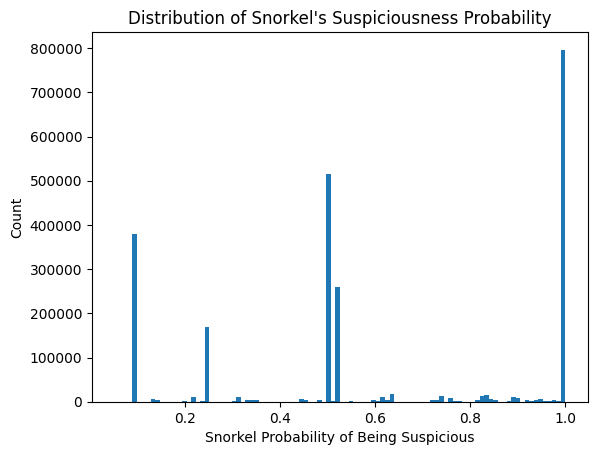

Combined LF Analysis Summary:


,j_gold_pos,Polarity_gold_pos,Coverage_gold_pos,Overlaps_gold_pos,Conflicts_gold_pos,Correct_gold_pos,Incorrect_gold_pos,Emp. Acc._gold_pos,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_local_60_sig,0,[1],0.666667,0.666667,0.0,16,0,1.0,0,[1],0.517766,0.492386,0.406091,102,0,1.0
lf_local_60_sig_3,1,[1],0.583333,0.583333,0.0,14,0,1.0,1,[1],0.426396,0.426396,0.355330,84,0,1.0
lf_local_60_sig_6,2,[1],0.291667,0.291667,0.0,7,0,1.0,2,[1],0.340102,0.340102,0.269036,67,0,1.0
lf_isolation_30_sig_7,3,[1],0.250000,0.250000,0.0,6,0,1.0,3,[1],0.182741,0.182741,0.111675,36,0,1.0
lf_isolation_60_sig_7,4,[1],0.166667,0.166667,0.0,4,0,1.0,4,[1],0.182741,0.182741,0.101523,36,0,1.0
lf_isolation_120_sig,5,[1],0.291667,0.291667,0.0,7,0,1.0,5,[1],0.060914,0.060914,0.060914,12,0,1.0
lf_isolation_120_sig_5,6,[1],0.291667,0.291667,0.0,7,0,1.0,6,[1],0.071066,0.071066,0.071066,14,0,1.0
lf_turnover_high_75,7,[1],0.291667,0.291667,0.0,7,0,1.0,7,[1],0.157360,0.157360,0.157360,31,0,1.0
lf_turnover_high_98,8,[1],0.166667,0.166667,0.0,4,0,1.0,8,[],0.000000,0.000000,0.000000,0,0,0.0
lf_volume_mkt_high,9,[1],0.333333,0.333333,0.0,8,0,1.0,9,[1],0.065990,0.065990,0.065990,13,0,1.0


Gold (CAR > 0): Caught 17 out of 24 known positives.
Gold (CAR <= 0): Caught 57 out of 197 known positives.
Non-gold: Caught 820099 out of 2341757 transactions.
Fraction of gold (CAR > 0) caught: 0.7083333333333334
Fraction of gold (CAR <= 0) caught: 0.2893401015228426
Fraction of non-gold caught: 0.3502067037698617


In [75]:
import time
from snorkel.labeling.model import LabelModel

# Create a parallel LF applier using your list of labeling functions (lfs)
#applier = PandasParallelLFApplier(lfs)

#df_D = df_D_new.copy"
# ----- Timing the LF "df_D_new_metrics.csv"Application -----
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from snorkel.labeling.apply.dask import DaskLFApplier

ddf = dd.from_pandas(df_D, npartitions=2)
applier = DaskLFApplier(lfs)

with ProgressBar():
    L_dask = applier.apply(ddf)   # L_dask is a Dask object
#L = L_dask.compute()              # L is a NumPy array
  # L is now a NumPy array after compute()
L = L_dask
# ----- Timing the LabelModel Training -----
label_model = LabelModel(cardinality=2, verbose=True)
start_time = time.time()
label_model.fit(L_train=L, n_epochs=200, lr=0.01, l2=0.0)
training_time = time.time() - start_time
print(f"LabelModel training took: {training_time:.2f} seconds")

# ----- Timing the Prediction Step -----
start_time = time.time()
y_prob = label_model.predict_proba(L)[:, 1]
y_pred = (y_prob >= 0.8).astype(int)
prediction_time = time.time() - start_time
print(f"LabelModel prediction took: {prediction_time:.2f} seconds")

# Save the results back to your DataFrame
df_D["snorkel_prob"] = y_prob
df_D["snorkel_pred"] = y_pred


import matplotlib.pyplot as plt

plt.hist(df_D["snorkel_prob"], bins=100)
plt.xlabel("Snorkel Probability of Being Suspicious")
plt.ylabel("Count")
plt.title("Distribution of Snorkel's Suspiciousness Probability")
plt.show()



import pandas as pd
from snorkel.labeling import LFAnalysis

# Create masks for each group.
mask_gold = (df_D["external_validation"] == 1)

# For gold rows, split into those where ANY effective CAR is positive versus none.
mask_gold_pos = mask_gold & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
mask_gold_neg = mask_gold & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

mask_nongold = (df_D["external_validation"] != 1)

# Subset your label matrix L using these masks.
L_gold_pos = L[mask_gold_pos]
gold_labels_gold_pos = df_D.loc[mask_gold_pos, "external_validation"].values

L_gold_neg = L[mask_gold_neg]
gold_labels_gold_neg = df_D.loc[mask_gold_neg, "external_validation"].values

L_nongold = L[mask_nongold]
nongold_labels = df_D.loc[mask_nongold, "external_validation"].values

# Run LFAnalysis on each subset.
lf_summary_gold_pos = LFAnalysis(L_gold_pos, lfs).lf_summary(gold_labels_gold_pos)
lf_summary_gold_neg = LFAnalysis(L_gold_neg, lfs).lf_summary(gold_labels_gold_neg)
lf_summary_nongold = LFAnalysis(L_nongold, lfs).lf_summary(nongold_labels)

# Optionally, add suffixes for clarity.
lf_summary_gold_pos = lf_summary_gold_pos.add_suffix("_gold_pos")
#lf_summary_gold_neg = lf_summary_gold_neg.add_suffix("_gold_neg")
lf_summary_nongold = lf_summary_nongold.add_suffix("_nongold")
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)

import pandas as pd

# Define a threshold for flagging transactions as suspicious (adjust as needed)
threshold = 0.9

# Gold transactions: external_validation == 1
gold_mask = (df_D["external_validation"] == 1)

# Among gold transactions, split into two groups based on effective CAR:
# Gold with at least one positive effective CAR (across CAR_30, CAR_60, CAR_120)
gold_pos_mask = gold_mask & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
# Gold with all effective CAR values non-positive
gold_neg_mask = gold_mask & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

# Count how many gold transactions in each group have snorkel_prob >= threshold.
caught_gold_pos_count = (df_D.loc[gold_pos_mask, "snorkel_prob"] >= threshold).sum()
caught_gold_neg_count = (df_D.loc[gold_neg_mask, "snorkel_prob"] >= threshold).sum()

print(f"Gold (CAR > 0): Caught {caught_gold_pos_count} out of {gold_pos_mask.sum()} known positives.")
print(f"Gold (CAR <= 0): Caught {caught_gold_neg_count} out of {gold_neg_mask.sum()} known positives.")

# Non-gold transactions: external_validation != 1
nongold_mask = (df_D["external_validation"] != 1)
caught_nongold_count = (df_D.loc[nongold_mask, "snorkel_prob"] >= threshold).sum()
print(f"Non-gold: Caught {caught_nongold_count} out of {nongold_mask.sum()} transactions.")

# Print fractions (using conditional expressions in case a group is empty)
fraction_gold_pos = caught_gold_pos_count / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else None
fraction_gold_neg = caught_gold_neg_count / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else None
fraction_nongold = caught_nongold_count / nongold_mask.sum() if nongold_mask.sum() > 0 else None

print("Fraction of gold (CAR > 0) caught:", fraction_gold_pos)
print("Fraction of gold (CAR <= 0) caught:", fraction_gold_neg)
print("Fraction of non-gold caught:", fraction_nongold)


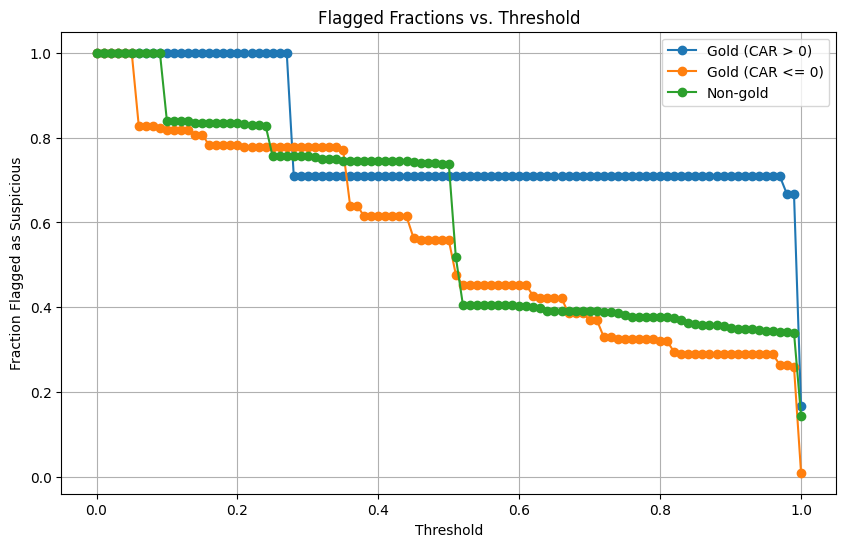

Best threshold based on maximum gap: 0.970 with gap 0.366


In [76]:

# Define a range of candidate thresholds (e.g., from 0 to 1 in 0.01 steps)
thresholds = np.linspace(0, 1, 101)

# Precompute masks that are independent of the threshold
gold_mask = (df_D["external_validation"] == 1)
gold_pos_mask = gold_mask & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
gold_neg_mask = gold_mask & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
nongold_mask = (df_D["external_validation"] != 1)

# Lists to store fractions for each threshold
fractions_gold_pos = []
fractions_gold_neg = []
fractions_nongold = []
gaps = []  # gap = fraction_gold_pos - max(fraction_gold_neg, fraction_nongold)

for thr in thresholds:
    caught_gold_pos = (df_D.loc[gold_pos_mask, "snorkel_prob"] >= thr).sum()
    caught_gold_neg = (df_D.loc[gold_neg_mask, "snorkel_prob"] >= thr).sum()
    caught_nongold = (df_D.loc[nongold_mask, "snorkel_prob"] >= thr).sum()
    
    # Calculate fractions (with a fallback to 0 if group is empty)
    frac_gold_pos = caught_gold_pos / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else 0
    frac_gold_neg = caught_gold_neg / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else 0
    frac_nongold = caught_nongold / nongold_mask.sum() if nongold_mask.sum() > 0 else 0
    
    fractions_gold_pos.append(frac_gold_pos)
    fractions_gold_neg.append(frac_gold_neg)
    fractions_nongold.append(frac_nongold)
    
    gap = frac_gold_pos - max(frac_gold_neg, frac_nongold)
    gaps.append(gap)

# Convert lists to numpy arrays for easier processing
fractions_gold_pos = np.array(fractions_gold_pos)
fractions_gold_neg = np.array(fractions_gold_neg)
fractions_nongold = np.array(fractions_nongold)
gaps = np.array(gaps)

# Plot the fractions as lines
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fractions_gold_pos, label="Gold (CAR > 0)", marker="o")
plt.plot(thresholds, fractions_gold_neg, label="Gold (CAR <= 0)", marker="o")
plt.plot(thresholds, fractions_nongold, label="Non-gold", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Fraction Flagged as Suspicious")
plt.title("Flagged Fractions vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Determine the threshold with the maximum gap
max_gap_index = np.argmax(gaps)
best_threshold = thresholds[max_gap_index]
max_gap_value = gaps[max_gap_index]
print(f"Best threshold based on maximum gap: {best_threshold:.3f} with gap {max_gap_value:.3f}")

In [44]:
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_nongold], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)


Combined LF Analysis Summary:


,j_gold_pos,Polarity_gold_pos,Coverage_gold_pos,Overlaps_gold_pos,Conflicts_gold_pos,Correct_gold_pos,Incorrect_gold_pos,Emp. Acc._gold_pos,j_nongold,Polarity_nongold,Coverage_nongold,Overlaps_nongold,Conflicts_nongold,Correct_nongold,Incorrect_nongold,Emp. Acc._nongold
lf_local_60_sig,0,[1],0.666667,0.666667,0.0,16,0,1.0,0,[1],0.682366,0.544972,0.0,0,1597935,0.0
lf_local_60_sig_3,1,[1],0.583333,0.583333,0.0,14,0,1.0,1,[1],0.341227,0.341227,0.0,0,799071,0.0
lf_local_60_sig_6,2,[1],0.291667,0.291667,0.0,7,0,1.0,2,[1],0.253137,0.253137,0.0,0,592785,0.0
lf_isolation_30_sig_7,3,[1],0.250000,0.250000,0.0,6,0,1.0,3,[1],0.179894,0.169193,0.0,0,421269,0.0
lf_isolation_60_sig_7,4,[1],0.166667,0.166667,0.0,4,0,1.0,4,[1],0.172587,0.170997,0.0,0,404157,0.0
lf_isolation_120_sig,5,[1],0.291667,0.291667,0.0,7,0,1.0,5,[1],0.185872,0.185872,0.0,0,435266,0.0
lf_isolation_120_sig_5,6,[1],0.291667,0.291667,0.0,7,0,1.0,6,[1],0.281048,0.262017,0.0,0,658146,0.0
lf_turnover_high_75,7,[],0.000000,0.000000,0.0,0,0,0.0,7,[],0.000000,0.000000,0.0,0,0,0.0
lf_turnover_high_98,8,[],0.000000,0.000000,0.0,0,0,0.0,8,[],0.000000,0.000000,0.0,0,0,0.0
lf_volume_mkt_high,9,[],0.000000,0.000000,0.0,0,0,0.0,9,[],0.000000,0.000000,0.0,0,0,0.0


[########################################] | 100% Completed | 59.29 s


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                                                       | 0/200 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=1.321]
INFO:root:[10 epochs]: TRAIN:[loss=0.416]
INFO:root:[20 epochs]: TRAIN:[loss=0.348]
INFO:root:[30 epochs]: TRAIN:[loss=0.201]
INFO:root:[40 epochs]: TRAIN:[loss=0.185]
INFO:root:[50 epochs]: TRAIN:[loss=0.168]
INFO:root:[60 epochs]: TRAIN:[loss=0.139]
INFO:root:[70 epochs]: TRAIN:[loss=0.113]
INFO:root:[80 epochs]: TRAIN:[loss=0.095]
INFO:root:[90 epochs]: TRAIN:[loss=0.089]
 46%|███████████████████████████████████                                          | 91/200 [00:00<00:00, 899.69epoch/s]INFO:root:[100 epochs]: TRAIN:[loss=0.086]
INFO:root:[110 epochs]: TRAIN:[loss=0.083]
INFO:root:[120 epochs]: TRAIN:[loss=0.081]
INFO:root:[130 epochs]: TRAIN:[loss=0.080]
INFO:root:[140 epochs]: TRAIN:[loss=0.080]
INFO:root:[150 epochs]: TRAIN:[loss=0.079]
INFO:root:[160 epochs]: TRAIN:[l

LabelModel training took: 0.75 seconds
LabelModel prediction took: 0.39 seconds


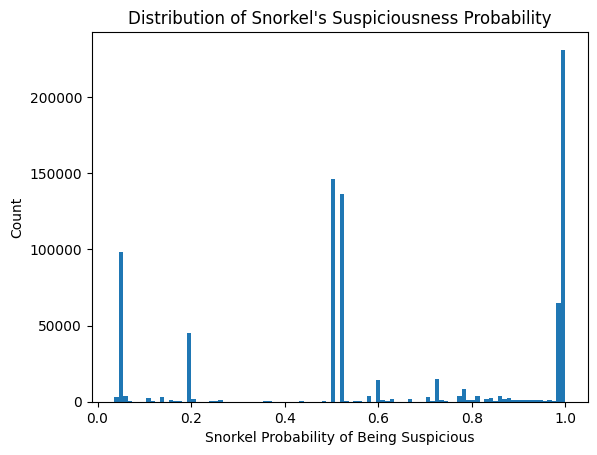

Combined LF Analysis Summary:


,j_gold_pos,Polarity_gold_pos,Coverage_gold_pos,Overlaps_gold_pos,Conflicts_gold_pos,Correct_gold_pos,Incorrect_gold_pos,Emp. Acc._gold_pos,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_local_60_sig,0,[1],1.0,1.0,0.0,1,0,1.0,0,[1],1.0,1.0,1.0,1,0,1.0
lf_local_60_sig_3,1,[],0.0,0.0,0.0,0,0,0.0,1,[],0.0,0.0,0.0,0,0,0.0
lf_local_60_sig_6,2,[],0.0,0.0,0.0,0,0,0.0,2,[],0.0,0.0,0.0,0,0,0.0
lf_isolation_30_sig_7,3,[],0.0,0.0,0.0,0,0,0.0,3,[],0.0,0.0,0.0,0,0,0.0
lf_isolation_60_sig_7,4,[1],1.0,1.0,0.0,1,0,1.0,4,[],0.0,0.0,0.0,0,0,0.0
lf_isolation_120_sig,5,[],0.0,0.0,0.0,0,0,0.0,5,[],0.0,0.0,0.0,0,0,0.0
lf_isolation_120_sig_5,6,[1],1.0,1.0,0.0,1,0,1.0,6,[],0.0,0.0,0.0,0,0,0.0
lf_turnover_high_75,7,[1],1.0,1.0,0.0,1,0,1.0,7,[],0.0,0.0,0.0,0,0,0.0
lf_turnover_high_98,8,[],0.0,0.0,0.0,0,0,0.0,8,[],0.0,0.0,0.0,0,0,0.0
lf_volume_mkt_high,9,[1],1.0,1.0,0.0,1,0,1.0,9,[],0.0,0.0,0.0,0,0,0.0


Gold (CAR > 0): Caught 1 out of 1 known positives.
Gold (CAR <= 0): Caught 0 out of 1 known positives.
Non-gold: Caught 303970 out of 829021 transactions.
Fraction of gold (CAR > 0) caught: 1.0
Fraction of gold (CAR <= 0) caught: 0.0
Fraction of non-gold caught: 0.36666139940966513


In [77]:
import time
from snorkel.labeling.model import LabelModel

# Create a parallel LF applier using your list of labeling functions (lfs)
#applier = PandasParallelLFApplier(lfs)

#df_D = df_D_new.copy"
# ----- Timing the LF "df_D_new_metrics.csv"Application -----
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from snorkel.labeling.apply.dask import DaskLFApplier

ddf = dd.from_pandas(df_A, npartitions=2)
applier = DaskLFApplier(lfs)

with ProgressBar():
    L_dask = applier.apply(ddf)   # L_dask is a Dask object
#L = L_dask.compute()              # L is a NumPy array
  # L is now a NumPy array after compute()
L = L_dask
# ----- Timing the LabelModel Training -----
label_model = LabelModel(cardinality=2, verbose=True)
start_time = time.time()
label_model.fit(L_train=L, n_epochs=200, lr=0.01, l2=0.0)
training_time = time.time() - start_time
print(f"LabelModel training took: {training_time:.2f} seconds")

# ----- Timing the Prediction Step -----
start_time = time.time()
y_prob = label_model.predict_proba(L)[:, 1]
y_pred = (y_prob >= 0.8).astype(int)
prediction_time = time.time() - start_time
print(f"LabelModel prediction took: {prediction_time:.2f} seconds")

# Save the results back to your DataFrame
df_A["snorkel_prob"] = y_prob
df_A["snorkel_pred"] = y_pred


import matplotlib.pyplot as plt

plt.hist(df_A["snorkel_prob"], bins=100)
plt.xlabel("Snorkel Probability of Being Suspicious")
plt.ylabel("Count")
plt.title("Distribution of Snorkel's Suspiciousness Probability")
plt.show()



import pandas as pd
from snorkel.labeling import LFAnalysis

# Create masks for each group.
mask_gold = (df_A["external_validation"] == 1)

# For gold rows, split into those where ANY effective CAR is positive versus none.
mask_gold_pos = mask_gold & (
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)
mask_gold_neg = mask_gold & ~(
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)

mask_nongold = (df_A["external_validation"] != 1)

# Subset your label matrix L using these masks.
L_gold_pos = L[mask_gold_pos]
gold_labels_gold_pos = df_A.loc[mask_gold_pos, "external_validation"].values

L_gold_neg = L[mask_gold_neg]
gold_labels_gold_neg = df_A.loc[mask_gold_neg, "external_validation"].values

L_nongold = L[mask_nongold]
nongold_labels = df_A.loc[mask_nongold, "external_validation"].values

# Run LFAnalysis on each subset.
lf_summary_gold_pos = LFAnalysis(L_gold_pos, lfs).lf_summary(gold_labels_gold_pos)
lf_summary_gold_neg = LFAnalysis(L_gold_neg, lfs).lf_summary(gold_labels_gold_neg)
lf_summary_nongold = LFAnalysis(L_nongold, lfs).lf_summary(nongold_labels)

# Optionally, add suffixes for clarity.
lf_summary_gold_pos = lf_summary_gold_pos.add_suffix("_gold_pos")
#lf_summary_gold_neg = lf_summary_gold_neg.add_suffix("_gold_neg")
lf_summary_nongold = lf_summary_nongold.add_suffix("_nongold")
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)

import pandas as pd

# Define a threshold for flagging transactions as suspicious (adjust as needed)
threshold = 0.9

# Gold transactions: external_validation == 1
gold_mask = (df_A["external_validation"] == 1)

# Among gold transactions, split into two groups based on effective CAR:
# Gold with at least one positive effective CAR (across CAR_30, CAR_60, CAR_120)
gold_pos_mask = gold_mask & (
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)
# Gold with all effective CAR values non-positive
gold_neg_mask = gold_mask & ~(
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)

# Count how many gold transactions in each group have snorkel_prob >= threshold.
caught_gold_pos_count = (df_A.loc[gold_pos_mask, "snorkel_prob"] >= threshold).sum()
caught_gold_neg_count = (df_A.loc[gold_neg_mask, "snorkel_prob"] >= threshold).sum()

print(f"Gold (CAR > 0): Caught {caught_gold_pos_count} out of {gold_pos_mask.sum()} known positives.")
print(f"Gold (CAR <= 0): Caught {caught_gold_neg_count} out of {gold_neg_mask.sum()} known positives.")

# Non-gold transactions: external_validation != 1
nongold_mask = (df_A["external_validation"] != 1)
caught_nongold_count = (df_A.loc[nongold_mask, "snorkel_prob"] >= threshold).sum()
print(f"Non-gold: Caught {caught_nongold_count} out of {nongold_mask.sum()} transactions.")

# Print fractions (using conditional expressions in case a group is empty)
fraction_gold_pos = caught_gold_pos_count / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else None
fraction_gold_neg = caught_gold_neg_count / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else None
fraction_nongold = caught_nongold_count / nongold_mask.sum() if nongold_mask.sum() > 0 else None

print("Fraction of gold (CAR > 0) caught:", fraction_gold_pos)
print("Fraction of gold (CAR <= 0) caught:", fraction_gold_neg)
print("Fraction of non-gold caught:", fraction_nongold)


     threshold  gold_pos_frac  gold_neg_frac  nongold_frac       gap
0         0.00            1.0            1.0      1.000000  0.000000
1         0.01            1.0            1.0      1.000000  0.000000
2         0.02            1.0            1.0      1.000000  0.000000
3         0.03            1.0            1.0      1.000000  0.000000
4         0.04            1.0            1.0      0.996489  0.000000
..         ...            ...            ...           ...       ...
96        0.96            1.0            0.0      0.358947  0.641053
97        0.97            1.0            0.0      0.357914  0.642086
98        0.98            1.0            0.0      0.357411  0.642589
99        0.99            1.0            0.0      0.278808  0.721192
100       1.00            0.0            0.0      0.108046 -0.108046

[101 rows x 5 columns]


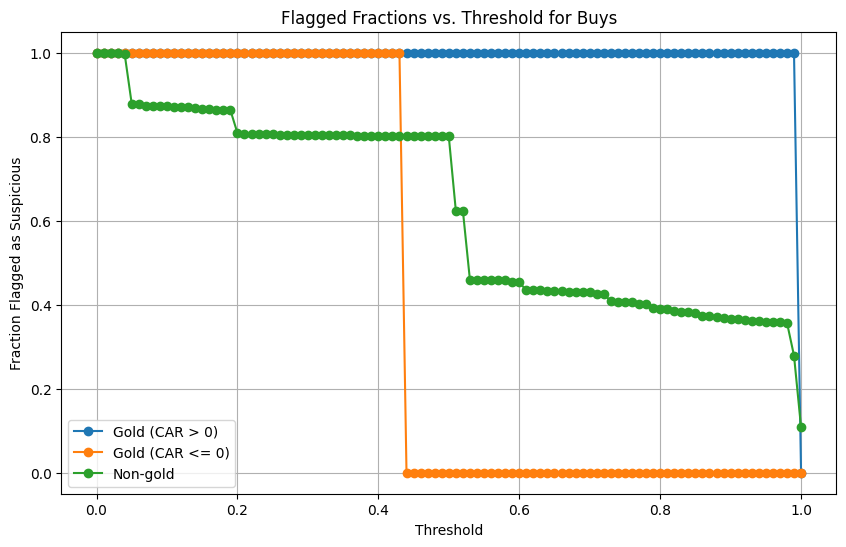

Best threshold for buys based on maximum gap: 0.990 with gap 0.721


In [78]:

# Define a range of candidate thresholds (e.g., 0 to 1 in 0.01 increments)
thresholds = np.linspace(0, 1, 101)

# Precompute masks for buys in df_A:
# "Gold" buys are those with external_validation == 1.
gold_mask = (df_A["external_validation"] == 1)
# Gold buys are split based on whether any of the effective CAR values are positive.
gold_pos_mask = gold_mask & (
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)
gold_neg_mask = gold_mask & ~(
    (df_A["effective_CAR_30_after"] > 0) |
    (df_A["effective_CAR_60_after"] > 0) |
    (df_A["effective_CAR_120_after"] > 0)
)
# Nongold buys
nongold_mask = (df_A["external_validation"] != 1)

# Prepare lists to store fractions for each threshold.
results = []

for thr in thresholds:
    # Count flagged transactions for each group
    caught_gold_pos = (df_A.loc[gold_pos_mask, "snorkel_prob"] >= thr).sum()
    caught_gold_neg = (df_A.loc[gold_neg_mask, "snorkel_prob"] >= thr).sum()
    caught_nongold   = (df_A.loc[nongold_mask, "snorkel_prob"] >= thr).sum()
    
    # Compute fractions (avoid division by zero)
    frac_gold_pos = caught_gold_pos / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else 0
    frac_gold_neg = caught_gold_neg / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else 0
    frac_nongold  = caught_nongold   / nongold_mask.sum()   if nongold_mask.sum() > 0 else 0
    
    # Define gap as the difference between gold_pos fraction and the higher of gold_neg or nongold fractions.
    gap = frac_gold_pos - max(frac_gold_neg, frac_nongold)
    
    results.append({
        "threshold": thr,
        "gold_pos_frac": frac_gold_pos,
        "gold_neg_frac": frac_gold_neg,
        "nongold_frac": frac_nongold,
        "gap": gap
    })

# Convert results to a DataFrame for easier inspection
results_df = pd.DataFrame(results)
print(results_df)

# Plot the fractions as lines
plt.figure(figsize=(10, 6))
plt.plot(results_df["threshold"], results_df["gold_pos_frac"], label="Gold (CAR > 0)", marker="o")
plt.plot(results_df["threshold"], results_df["gold_neg_frac"], label="Gold (CAR <= 0)", marker="o")
plt.plot(results_df["threshold"], results_df["nongold_frac"], label="Non-gold", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Fraction Flagged as Suspicious")
plt.title("Flagged Fractions vs. Threshold for Buys")
plt.legend()
plt.grid(True)
plt.show()

# Determine the threshold with the maximum gap
max_gap_index = results_df["gap"].idxmax()
best_threshold = results_df.loc[max_gap_index, "threshold"]
max_gap_value = results_df.loc[max_gap_index, "gap"]

print(f"Best threshold for buys based on maximum gap: {best_threshold:.3f} with gap {max_gap_value:.3f}")

In [79]:


# For df_D (e.g., sell transactions)
df_D = df_D.copy()
df_D["best_threshold"] = 0.970
df_D["y_pred"] = (df_D["snorkel_prob"] >= df_D["best_threshold"]).astype(int)

# For df_A (e.g., buy transactions)
df_A = df_A.copy()
df_A["best_threshold"] = 0.990
df_A["y_pred"] = (df_A["snorkel_prob"] >= df_A["best_threshold"]).astype(int)

# Merge the two DataFrames row-wise
df_full = pd.concat([df_D, df_A], axis=0, ignore_index=True)

# Export the merged DataFrame to CSV
df_full.to_csv("merged_txns_SNORKEL.csv", index=False)
print("Merged DataFrame saved to 'merged_txns_SNORKEL.csv'.")


Merged DataFrame saved to 'merged_txns_SNORKEL.csv'.


# old code

In [16]:
print(caught_nongold_count)

959359


In [63]:

lfs = [
    # Basic numeric LFs

    #lf_deviation_from_trader_mean_120,

    #lf_deviation_from_global_mean_120,
    #lf_combo_deviation_trader_mean,
    #lf_combo_deviation_global_mean,
    lf_local_30_sig,
    #lf_local_30_sig_6,
    lf_local_60_sig,
    lf_local_60_sig_3,
    lf_local_60_sig_6, #(last hange 5.18)
    #lf_isolation_30_sig_4,
    #lf_isolation_60_sig_4,
    
    lf_local_120_sig,
    #lf_local_120_sig_75,
    #lf_local_120_sig_25,
    lf_isolation_30_sig_7,
    lf_isolation_60_sig_7,
    lf_isolation_120_sig,
    lf_isolation_120_sig_5,
    #lf_effective_car_30,
    #lf_effective_car_60,
    #lf_effective_car_120,
   #lf_abnormal_intraday_return,
    #lf_few_references_30, 5.29Fraction of gold (CAR > 0) caught: 0.375
    #Fraction of gold (CAR <= 0) caught: 0.2893401015228426
    #Fraction of non-gold caught: 0.40638375373704444
    #lf_few_references_60,
    #lf_few_references_120,

    # Trader-level LFs
    #lf_deviation_from_trader_mean,
    #lf_deviation_from_global_mean,

    # Combined LFs
    #lf_combo_local_sig,
    #lf_combo_isolation_sig,
    #lf_combo_effective_car,
    #lf_combo_few_references,
    #lf_combo_anomaly_score_sig,
    #lf_combo_event,
    lf_known_fraud,
    #lf_combo_effective_car_negative
]

[########################################] | 100% Completed | 300.87 s


INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                                                       | 0/200 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=10.354]
INFO:root:[10 epochs]: TRAIN:[loss=4.453]
INFO:root:[20 epochs]: TRAIN:[loss=0.871]
 12%|████████▊                                                                    | 23/200 [00:00<00:00, 228.84epoch/s]INFO:root:[30 epochs]: TRAIN:[loss=0.535]
INFO:root:[40 epochs]: TRAIN:[loss=0.215]
INFO:root:[50 epochs]: TRAIN:[loss=0.189]
INFO:root:[60 epochs]: TRAIN:[loss=0.183]
INFO:root:[70 epochs]: TRAIN:[loss=0.183]
 39%|██████████████████████████████                                               | 78/200 [00:00<00:00, 413.67epoch/s]INFO:root:[80 epochs]: TRAIN:[loss=0.183]
INFO:root:[90 epochs]: TRAIN:[loss=0.181]
INFO:root:[100 epochs]: TRAIN:[loss=0.177]
INFO:root:[110 epochs]: TRAIN:[loss=0.167]
INFO:root:[120 epochs]: TRAIN:[loss=0.146]
 62%|████████████████████████████████████

LabelModel training took: 2.64 seconds
LabelModel prediction took: 1.25 seconds


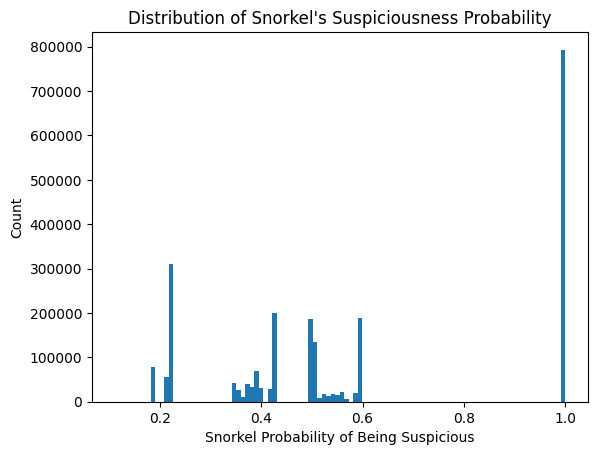

Combined LF Analysis Summary:


,j_gold_pos,Polarity_gold_pos,Coverage_gold_pos,Overlaps_gold_pos,Conflicts_gold_pos,Correct_gold_pos,Incorrect_gold_pos,Emp. Acc._gold_pos,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_local_30_sig,0,[1],0.666667,0.666667,0.0,16,0,1.0,0,[1],0.548223,0.548223,0.441624,108,0,1.0
lf_local_60_sig,1,[1],0.666667,0.666667,0.0,16,0,1.0,1,[1],0.517766,0.517766,0.406091,102,0,1.0
lf_local_60_sig_3,2,[1],0.708333,0.708333,0.0,17,0,1.0,2,[1],0.624365,0.624365,0.512690,123,0,1.0
lf_local_60_sig_6,3,[1],0.291667,0.291667,0.0,7,0,1.0,3,[1],0.340102,0.340102,0.269036,67,0,1.0
lf_local_120_sig,4,[1],0.583333,0.583333,0.0,14,0,1.0,4,[1],0.766497,0.685279,0.573604,151,0,1.0
lf_isolation_30_sig_7,5,[1],0.250000,0.250000,0.0,6,0,1.0,5,[1],0.182741,0.182741,0.111675,36,0,1.0
lf_isolation_60_sig_7,6,[1],0.166667,0.166667,0.0,4,0,1.0,6,[1],0.182741,0.182741,0.101523,36,0,1.0
lf_isolation_120_sig,7,[1],0.291667,0.291667,0.0,7,0,1.0,7,[1],0.060914,0.060914,0.060914,12,0,1.0
lf_isolation_120_sig_5,8,[1],0.291667,0.291667,0.0,7,0,1.0,8,[1],0.071066,0.071066,0.071066,14,0,1.0
lf_combo_local_sig,9,[1],0.583333,0.583333,0.0,14,0,1.0,9,[1],0.604061,0.604061,0.532995,119,0,1.0


Gold (CAR > 0): Caught 9 out of 24 known positives.
Gold (CAR <= 0): Caught 51 out of 197 known positives.
Non-gold: Caught 793133 out of 2341757 transactions.
Fraction of gold (CAR > 0) caught: 0.375
Fraction of gold (CAR <= 0) caught: 0.25888324873096447
Fraction of non-gold caught: 0.33869141845204265


In [64]:
import time
from snorkel.labeling.model import LabelModel

# Create a parallel LF applier using your list of labeling functions (lfs)
#applier = PandasParallelLFApplier(lfs)

# ----- Timing the LF Application -----
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from snorkel.labeling.apply.dask import DaskLFApplier

ddf = dd.from_pandas(df_D, npartitions=2)
applier = DaskLFApplier(lfs)

with ProgressBar():
    L_dask = applier.apply(ddf)   # L_dask is a Dask object
#L = L_dask.compute()              # L is a NumPy array
  # L is now a NumPy array after compute()
L = L_dask
# ----- Timing the LabelModel Training -----
label_model = LabelModel(cardinality=2, verbose=True)
start_time = time.time()
label_model.fit(L_train=L, n_epochs=200, lr=0.01, l2=0.0)
training_time = time.time() - start_time
print(f"LabelModel training took: {training_time:.2f} seconds")

# ----- Timing the Prediction Step -----
start_time = time.time()
y_prob = label_model.predict_proba(L)[:, 1]
y_pred = (y_prob >= 0.8).astype(int)
prediction_time = time.time() - start_time
print(f"LabelModel prediction took: {prediction_time:.2f} seconds")

# Save the results back to your DataFrame
df_D["snorkel_prob"] = y_prob
df_D["snorkel_pred"] = y_pred


import matplotlib.pyplot as plt

plt.hist(df_D["snorkel_prob"], bins=100)
plt.xlabel("Snorkel Probability of Being Suspicious")
plt.ylabel("Count")
plt.title("Distribution of Snorkel's Suspiciousness Probability")
plt.show()



import pandas as pd
from snorkel.labeling import LFAnalysis

# Create masks for each group.
mask_gold = (df_D["external_validation"] == 1)

# For gold rows, split into those where ANY effective CAR is positive versus none.
mask_gold_pos = mask_gold & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
mask_gold_neg = mask_gold & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

mask_nongold = (df_D["external_validation"] != 1)

# Subset your label matrix L using these masks.
L_gold_pos = L[mask_gold_pos]
gold_labels_gold_pos = df_D.loc[mask_gold_pos, "external_validation"].values

L_gold_neg = L[mask_gold_neg]
gold_labels_gold_neg = df_D.loc[mask_gold_neg, "external_validation"].values

L_nongold = L[mask_nongold]
nongold_labels = df_D.loc[mask_nongold, "external_validation"].values

# Run LFAnalysis on each subset.
lf_summary_gold_pos = LFAnalysis(L_gold_pos, lfs).lf_summary(gold_labels_gold_pos)
lf_summary_gold_neg = LFAnalysis(L_gold_neg, lfs).lf_summary(gold_labels_gold_neg)
lf_summary_nongold = LFAnalysis(L_nongold, lfs).lf_summary(nongold_labels)

# Optionally, add suffixes for clarity.
lf_summary_gold_pos = lf_summary_gold_pos.add_suffix("_gold_pos")
#lf_summary_gold_neg = lf_summary_gold_neg.add_suffix("_gold_neg")
lf_summary_nongold = lf_summary_nongold.add_suffix("_nongold")
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)

import pandas as pd

# Define a threshold for flagging transactions as suspicious (adjust as needed)
threshold = 0.9

# Gold transactions: external_validation == 1
gold_mask = (df_D["external_validation"] == 1)

# Among gold transactions, split into two groups based on effective CAR:
# Gold with at least one positive effective CAR (across CAR_30, CAR_60, CAR_120)
gold_pos_mask = gold_mask & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
# Gold with all effective CAR values non-positive
gold_neg_mask = gold_mask & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

# Count how many gold transactions in each group have snorkel_prob >= threshold.
caught_gold_pos_count = (df_D.loc[gold_pos_mask, "snorkel_prob"] >= threshold).sum()
caught_gold_neg_count = (df_D.loc[gold_neg_mask, "snorkel_prob"] >= threshold).sum()

print(f"Gold (CAR > 0): Caught {caught_gold_pos_count} out of {gold_pos_mask.sum()} known positives.")
print(f"Gold (CAR <= 0): Caught {caught_gold_neg_count} out of {gold_neg_mask.sum()} known positives.")

# Non-gold transactions: external_validation != 1
nongold_mask = (df_D["external_validation"] != 1)
caught_nongold_count = (df_D.loc[nongold_mask, "snorkel_prob"] >= threshold).sum()
print(f"Non-gold: Caught {caught_nongold_count} out of {nongold_mask.sum()} transactions.")

# Print fractions (using conditional expressions in case a group is empty)
fraction_gold_pos = caught_gold_pos_count / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else None
fraction_gold_neg = caught_gold_neg_count / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else None
fraction_nongold = caught_nongold_count / nongold_mask.sum() if nongold_mask.sum() > 0 else None

print("Fraction of gold (CAR > 0) caught:", fraction_gold_pos)
print("Fraction of gold (CAR <= 0) caught:", fraction_gold_neg)
print("Fraction of non-gold caught:", fraction_nongold)


In [65]:
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_nongold], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)

Combined LF Analysis Summary:


,j_gold_pos,Polarity_gold_pos,Coverage_gold_pos,Overlaps_gold_pos,Conflicts_gold_pos,Correct_gold_pos,Incorrect_gold_pos,Emp. Acc._gold_pos,j_nongold,Polarity_nongold,Coverage_nongold,Overlaps_nongold,Conflicts_nongold,Correct_nongold,Incorrect_nongold,Emp. Acc._nongold
lf_local_30_sig,0,[1],0.666667,0.666667,0.0,16,0,1.0,0,[1],0.708886,0.702651,0.0,0,1660038,0.0
lf_local_60_sig,1,[1],0.666667,0.666667,0.0,16,0,1.0,1,[1],0.682366,0.682366,0.0,0,1597935,0.0
lf_local_60_sig_3,2,[1],0.708333,0.708333,0.0,17,0,1.0,2,[1],0.809440,0.752286,0.0,0,1895512,0.0
lf_local_60_sig_6,3,[1],0.291667,0.291667,0.0,7,0,1.0,3,[1],0.253137,0.253137,0.0,0,592785,0.0
lf_local_120_sig,4,[1],0.583333,0.583333,0.0,14,0,1.0,4,[1],0.661047,0.657005,0.0,0,1548011,0.0
lf_isolation_30_sig_7,5,[1],0.250000,0.250000,0.0,6,0,1.0,5,[1],0.179894,0.178296,0.0,0,421269,0.0
lf_isolation_60_sig_7,6,[1],0.166667,0.166667,0.0,4,0,1.0,6,[1],0.172587,0.171918,0.0,0,404157,0.0
lf_isolation_120_sig,7,[1],0.291667,0.291667,0.0,7,0,1.0,7,[1],0.185872,0.185872,0.0,0,435266,0.0
lf_isolation_120_sig_5,8,[1],0.291667,0.291667,0.0,7,0,1.0,8,[1],0.281048,0.272028,0.0,0,658146,0.0
lf_combo_local_sig,9,[1],0.583333,0.583333,0.0,14,0,1.0,9,[1],0.520409,0.520409,0.0,0,1218672,0.0


In [81]:

threshold = 0.569

# Gold transactions: external_validation == 1
gold_mask = (df_D["external_validation"] == 1)

# Among gold transactions, split into two groups based on effective CAR:
# Gold with at least one positive effective CAR (across CAR_30, CAR_60, CAR_120)
gold_pos_mask = gold_mask & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
# Gold with all effective CAR values non-positive
gold_neg_mask = gold_mask & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

# Count how many gold transactions in each group have snorkel_prob >= threshold.
caught_gold_pos_count = (df_D.loc[gold_pos_mask, "snorkel_prob"] >= threshold).sum()
caught_gold_neg_count = (df_D.loc[gold_neg_mask, "snorkel_prob"] >= threshold).sum()

print(f"Gold (CAR > 0): Caught {caught_gold_pos_count} out of {gold_pos_mask.sum()} known positives.")
print(f"Gold (CAR <= 0): Caught {caught_gold_neg_count} out of {gold_neg_mask.sum()} known positives.")

# Non-gold transactions: external_validation != 1
nongold_mask = (df_D["external_validation"] != 1)
caught_nongold_count = (df_D.loc[nongold_mask, "snorkel_prob"] >= threshold).sum()
print(f"Non-gold: Caught {caught_nongold_count} out of {nongold_mask.sum()} transactions.")

# Print fractions (using conditional expressions in case a group is empty)
fraction_gold_pos = caught_gold_pos_count / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else None
fraction_gold_neg = caught_gold_neg_count / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else None
fraction_nongold = caught_nongold_count / nongold_mask.sum() if nongold_mask.sum() > 0 else None

print("Fraction of gold (CAR > 0) caught:", fraction_gold_pos)
print("Fraction of gold (CAR <= 0) caught:", fraction_gold_neg)
print("Fraction of non-gold caught:", fraction_nongold)

Gold (CAR > 0): Caught 17 out of 24 known positives.
Gold (CAR <= 0): Caught 55 out of 197 known positives.
Non-gold: Caught 1006961 out of 2341757 transactions.
Fraction of gold (CAR > 0) caught: 0.7083333333333334
Fraction of gold (CAR <= 0) caught: 0.27918781725888325
Fraction of non-gold caught: 0.43000234439354723


In [76]:

lfs = [

    lf_local_30_sig,
    #lf_local_30_sig_6,
    lf_local_60_sig,
    lf_local_60_sig_3,
    lf_local_60_sig_6, #(last hange 5.18)
    #lf_isolation_30_sig_4,
    #lf_isolation_60_sig_4,
    
    lf_local_120_sig,
    #lf_local_120_sig_75,
    #lf_local_120_sig_25,
    lf_isolation_30_sig_7,
    lf_isolation_60_sig_7,
    lf_isolation_120_sig,
    lf_isolation_120_sig_5,
    #lf_effective_car_30,
    #lf_effective_car_60,
    #lf_effective_car_120,
   #lf_abnormal_intraday_return,
    #lf_few_references_30, 5.29Fraction of gold (CAR > 0) caught: 0.375
    #Fraction of gold (CAR <= 0) caught: 0.2893401015228426
    #Fraction of non-gold caught: 0.40638375373704444
    #lf_few_references_60,
    #lf_few_references_120,
    lf_turnover_high,
    lf_volume_mkt_high,
    lf_volume_peer_high,
    lf_cumulative_turnover_high,
    #lf_combined_volume_turnover,   

    # Combined LFs
    #lf_combo_local_sig,
    #lf_combo_isolation_sig,
    #lf_combo_effective_car,
    #lf_combo_few_references,
    #lf_combo_anomaly_score_sig,
    #lf_combo_event,
    lf_known_fraud,
    #lf_combo_effective_car_negative
]

In [77]:
import time
from snorkel.labeling.model import LabelModel

# Create a parallel LF applier using your list of labeling functions (lfs)
#applier = PandasParallelLFApplier(lfs)

# ----- Timing the LF Application -----
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from snorkel.labeling.apply.dask import DaskLFApplier

ddf = dd.from_pandas(df_D, npartitions=2)
applier = DaskLFApplier(lfs)

with ProgressBar():
    L_dask = applier.apply(ddf)   # L_dask is a Dask object
#L = L_dask.compute()              # L is a NumPy array
  # L is now a NumPy array after compute()
L = L_dask
# ----- Timing the LabelModel Training -----
label_model = LabelModel(cardinality=2, verbose=True)
start_time = time.time()
label_model.fit(L_train=L, n_epochs=200, lr=0.01, l2=0.0)
training_time = time.time() - start_time
print(f"LabelModel training took: {training_time:.2f} seconds")

# ----- Timing the Prediction Step -----
start_time = time.time()
y_prob = label_model.predict_proba(L)[:, 1]
y_pred = (y_prob >= 0.8).astype(int)
prediction_time = time.time() - start_time
print(f"LabelModel prediction took: {prediction_time:.2f} seconds")

# Save the results back to your DataFrame
df_D["snorkel_prob"] = y_prob
df_D["snorkel_pred"] = y_pred


import matplotlib.pyplot as plt

plt.hist(df_D["snorkel_prob"], bins=100)
plt.xlabel("Snorkel Probability of Being Suspicious")
plt.ylabel("Count")
plt.title("Distribution of Snorkel's Suspiciousness Probability")
plt.show()



import pandas as pd
from snorkel.labeling import LFAnalysis

# Create masks for each group.
mask_gold = (df_D["external_validation"] == 1)

# For gold rows, split into those where ANY effective CAR is positive versus none.
mask_gold_pos = mask_gold & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
mask_gold_neg = mask_gold & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

mask_nongold = (df_D["external_validation"] != 1)

# Subset your label matrix L using these masks.
L_gold_pos = L[mask_gold_pos]
gold_labels_gold_pos = df_D.loc[mask_gold_pos, "external_validation"].values

L_gold_neg = L[mask_gold_neg]
gold_labels_gold_neg = df_D.loc[mask_gold_neg, "external_validation"].values

L_nongold = L[mask_nongold]
nongold_labels = df_D.loc[mask_nongold, "external_validation"].values

# Run LFAnalysis on each subset.
lf_summary_gold_pos = LFAnalysis(L_gold_pos, lfs).lf_summary(gold_labels_gold_pos)
lf_summary_gold_neg = LFAnalysis(L_gold_neg, lfs).lf_summary(gold_labels_gold_neg)
lf_summary_nongold = LFAnalysis(L_nongold, lfs).lf_summary(nongold_labels)

# Optionally, add suffixes for clarity.
lf_summary_gold_pos = lf_summary_gold_pos.add_suffix("_gold_pos")
#lf_summary_gold_neg = lf_summary_gold_neg.add_suffix("_gold_neg")
lf_summary_nongold = lf_summary_nongold.add_suffix("_nongold")
combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg], axis=1)
# Combine the summaries side by side.
#combined_summary = pd.concat([lf_summary_gold_pos, lf_summary_gold_neg, lf_summary_nongold], axis=1)
print("Combined LF Analysis Summary:")
display(combined_summary)

import pandas as pd

# Define a threshold for flagging transactions as suspicious (adjust as needed)
threshold = 0.9

# Gold transactions: external_validation == 1
gold_mask = (df_D["external_validation"] == 1)

# Among gold transactions, split into two groups based on effective CAR:
# Gold with at least one positive effective CAR (across CAR_30, CAR_60, CAR_120)
gold_pos_mask = gold_mask & (
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)
# Gold with all effective CAR values non-positive
gold_neg_mask = gold_mask & ~(
    (df_D["effective_CAR_30_after"] > 0) |
    (df_D["effective_CAR_60_after"] > 0) |
    (df_D["effective_CAR_120_after"] > 0)
)

# Count how many gold transactions in each group have snorkel_prob >= threshold.
caught_gold_pos_count = (df_D.loc[gold_pos_mask, "snorkel_prob"] >= threshold).sum()
caught_gold_neg_count = (df_D.loc[gold_neg_mask, "snorkel_prob"] >= threshold).sum()

print(f"Gold (CAR > 0): Caught {caught_gold_pos_count} out of {gold_pos_mask.sum()} known positives.")
print(f"Gold (CAR <= 0): Caught {caught_gold_neg_count} out of {gold_neg_mask.sum()} known positives.")

# Non-gold transactions: external_validation != 1
nongold_mask = (df_D["external_validation"] != 1)
caught_nongold_count = (df_D.loc[nongold_mask, "snorkel_prob"] >= threshold).sum()
print(f"Non-gold: Caught {caught_nongold_count} out of {nongold_mask.sum()} transactions.")

# Print fractions (using conditional expressions in case a group is empty)
fraction_gold_pos = caught_gold_pos_count / gold_pos_mask.sum() if gold_pos_mask.sum() > 0 else None
fraction_gold_neg = caught_gold_neg_count / gold_neg_mask.sum() if gold_neg_mask.sum() > 0 else None
fraction_nongold = caught_nongold_count / nongold_mask.sum() if nongold_mask.sum() > 0 else None

print("Fraction of gold (CAR > 0) caught:", fraction_gold_pos)
print("Fraction of gold (CAR <= 0) caught:", fraction_gold_neg)
print("Fraction of non-gold caught:", fraction_nongold)


KeyboardInterrupt: 

## lets make one more:
We want to know the turnover for a sell transaction, and a buy transaction.

We know how much they owned following that transaction: lets call it y
we know how much they owned prior: lets call it x.

for sells, your confidence is higher if you discard most of your prior stock. 

lets ignore buys for now.
so lets do prior = SHRS_OWND_FOLWNG_TRANS + TRANS_SHARES
sold = TRANS_SHARES

Then, we calculate proportion of TRANS_SHARES/(SHRS_OWND_FOLWNG_TRANS + TRANS_SHARES)

now what?

If they transacted cumulatively many stocks (so lets say 1 accession has multiple transactions of sell, then there shld be a way to comibine it.


## D-asking for mercy

In [ ]:
print(client.dashboard_link)
